# Boosted decision tree tutorial

***
## Introduction:
#### Boosted decision tree code:
We'll use the python API for the [XGBoost (eXtreme Gradient Boosting) library](https://github.com/dmlc/xgboost).

#### Data handling:
If you don't have [pandas](http://pandas.pydata.org/), you should get pandas. It's an amazing tool for exploring data in Python.
***
#### Install XGBoost:
Assuming you have python, numpy, matplotlib, and pandas installed, you just need to install XGBoost. Detailed installation instructions are [here](https://xgboost.readthedocs.io/en/latest/build.html). If you're on Ubuntu, just do this (in your terminal):
```bash
git clone --recursive https://github.com/dmlc/xgboost
cd xgboost
make
```
***
#### Links:
A lot of this was borrowed from other sources. These sources and other good places for information about XGBoost and BDTs in general are here:

XGBoost demo: [Example of how to use XGBoost Python Module to run Kaggle Higgs competition](https://github.com/dmlc/xgboost/tree/master/demo/kaggle-higgs)

Blog post by phunther: [Winning solution of Kaggle Higgs competition: what a single model can do?](https://no2147483647.wordpress.com/2014/09/17/winning-solution-of-kaggle-higgs-competition-what-a-single-model-can-do/)

XGBoost Kaggle Higgs solution: https://github.com/hetong007/higgsml

***

## Tutorial:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xgboost as xgb
import awkward as ak
import pickle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import sklearn.utils
import uproot
import glob
import warnings
import os
import os.path
import time
#!source ~/scripts/renew_cms.sh
from yahist import Hist1D
import processor.BDT_analysis as BDT_analysis
from coffea import processor, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

import Tools.objects
from Tools.nano_mapping import make_fileset, nano_mapping
from processor.meta_processor import get_sample_meta
from plots.helpers import makePlot, scale_and_merge
from sklearn.metrics import auc

from klepto.archives import dir_archive
from processor.default_accumulators import desired_output, add_processes_to_output
import production.weights
import postProcessing.makeCards
import postProcessing.datacard_comparison.compare_datacards as compare_datacards

#### Load data:

In [4]:
def get_SR_BR(signal_name, base_dir, version, year, BDT_params, background_category="none", flag_match_yields=True, gen_signal=True, gen_background=True):
    desired_output.update({"BDT_df": processor.column_accumulator(np.zeros(shape=(0,len(BDT_params)+1)))})
    if signal_name == "HCT":
        signal_files = glob.glob(base_dir + "*hct*.root")
    elif signal_name == "HUT":
        signal_files = glob.glob(base_dir + "*hut*.root")
    elif signal_name == "combined_HCT_HUT":
        signal_files = glob.glob(base_dir + "*hct*.root") + glob.glob(base_dir + "*hut*.root")
        
    if background_category=="none":
        remove_files = glob.glob(base_dir + "*hut*.root") + glob.glob(base_dir + "*hct*.root") + glob.glob(base_dir + "*data.root") + glob.glob(base_dir + "tt[0-9]lep.root")
        background_files = glob.glob(base_dir + "*.root")
        [background_files.remove(r) for r in remove_files]
    elif background_category=="fakes":
        background_files = [base_dir + "ttjets.root", base_dir + "wjets.root", base_dir + "ttg_1lep.root"]
    elif background_category=="flips":
        background_files = [base_dir + f for f in ["dyjets_m10-50.root", "dyjets_m50.root", "zg.root", "tw_dilep.root"]]#, "ww.root"]]
    elif background_category=="rares":
        remove_files = [base_dir + f for f in ["dyjets_m10-50.root", "dyjets_m50.root", "ww.root", "zg.root", "ttjets.root", "wjets.root", "ttg_1lep.root", "tw_dilep.root"]]
        remove_files += glob.glob(base_dir + "*hut*.root") + glob.glob(base_dir + "*hct*.root") + glob.glob(base_dir + "*data.root") + glob.glob(base_dir + "tt[0-9]lep.root")
        background_files = glob.glob(base_dir + "*.root")
        [background_files.remove(r) for r in remove_files]
    #print(background_files)
    concat_file = []
    for file in background_files:
        concat_file.append(file[file.rfind('/')+1:file.rfind('.')])
    print(concat_file)
    #print(len(background_files))
    #background_files = [base_dir + "ttjets.root"]
    signal_fileset = {}
    for s in signal_files:
        process_name = s[(s.rfind('/')+1):(s.rfind('.'))]
        signal_fileset[process_name] = [s]
    background_fileset = {}    
    for b in background_files:
        process_name = b[(b.rfind('/')+1):(b.rfind('.'))]
        background_fileset[process_name] = [b]

    exe_args = {
        'workers': 16,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        "skipbadfiles": True,
    }
    exe = processor.futures_executor
    with warnings.catch_warnings(): #Ignoring all RuntimeWarnings (there are a lot)
        warnings.simplefilter("ignore", category=RuntimeWarning)
        if gen_signal:
            signal_output = processor.run_uproot_job(
                signal_fileset,
                "Events",
                BDT_analysis.nano_analysis(year=year, variations=[], accumulator=desired_output, BDT_params=BDT_params, version=version),
                exe,
                exe_args,
                chunksize=250000,
            )
            signal_BDT_params = pd.DataFrame(data=signal_output["BDT_df"].value, columns=(["event"]+BDT_params))
            signal_BDT_params["Label"] = "s"
        else:
            signal_BDT_params = None
            
        if gen_background:
            background_output = processor.run_uproot_job(
                background_fileset,
                "Events",
                BDT_analysis.nano_analysis(year=year, variations=[], accumulator=desired_output, BDT_params=BDT_params, version=version),
                exe,
                exe_args,
                chunksize=250000,
            )
            background_BDT_params = pd.DataFrame(data=background_output["BDT_df"].value, columns=(["event"]+BDT_params))
            background_BDT_params["Label"] = "b"
            background_BDT_params = sklearn.utils.shuffle(background_BDT_params) #shuffle our background before we cut out a subset of it
    #background_BDT_params = background_BDT_params[:signal_BDT_params.shape[0]] #make the background only as large as the signal
        else:
            background_BDT_params = None
    if flag_match_yields and gen_signal and gen_background:
        signal_yield = sum(signal_BDT_params.weight)
        background_yield = sum(background_BDT_params.weight)
        SR_BR_ratio = signal_yield/background_yield
        print("signal yield:{}".format(signal_yield))
        print("background yield:{}".format(background_yield))
        print("SR/BR yield ratio:{}".format(SR_BR_ratio))
        signal_BDT_params.weight = signal_BDT_params.weight / SR_BR_ratio
        print("new signal yield:{}".format(sum(signal_BDT_params.weight)))
        print("new SR/BR yield ratio:{}".format(sum(signal_BDT_params.weight) / background_yield))
    if gen_signal and gen_background:
        full_data = pd.concat([signal_BDT_params, background_BDT_params], axis=0)
    else:
        full_data = None
    return (signal_BDT_params, background_BDT_params, full_data)

def process_file(fname, base_dir, BDT_params, version, year):
    fileset = {}
    process_name = fname[(fname.rfind('/')+1):(fname.rfind('.'))]
    fileset[process_name] = [fname]
    desired_output.update({"BDT_df": processor.column_accumulator(np.zeros(shape=(0,len(BDT_params)+1)))})
    exe_args = {
        'workers': 16,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        "skipbadfiles": True,
    }
    exe = processor.futures_executor
    with warnings.catch_warnings(): #Ignoring all RuntimeWarnings (there are a lot)
        warnings.simplefilter("ignore", category=RuntimeWarning)
        tmp_output = processor.run_uproot_job(
            fileset,
            "Events",
            BDT_analysis.nano_analysis(year=year, variations=[], accumulator=desired_output, BDT_params=BDT_params, version=version),
            exe,
            exe_args,
            chunksize=250000,
        )
    tmp_BDT_params = pd.DataFrame(data=tmp_output["BDT_df"].value, columns=(["event"]+BDT_params))
    return tmp_BDT_params

def load_SR_BR_from_babies(baby_dir="/home/users/cmcmahon/fcnc/ana/analysis/helpers/BDT/babies/2018/dilep/"): 
    signal_BDT_params = pd.DataFrame()
    background_BDT_params = pd.DataFrame()
    for file in glob.glob(baby_dir + "*.root"):
        tree = uproot.open(file)['T']
        process_name = file[(file.rfind('/')+1):(file.rfind('.'))]
        df = pd.DataFrame()
        df_values = tree.arrays()
        df["Most_Forward_pt"] = np.array(df_values["Most_Forward_pt"])
        df["HT"] = np.array(df_values["HT"])
        df["LeadLep_eta"] = np.array(df_values["LeadLep_eta"])
        df["LeadLep_pt"] = np.array(df_values["LeadLep_pt"])
        df["LeadLep_dxy"] = np.array(df_values["LeadLep_dxy"])
        df["LeadLep_dz"] = np.array(df_values["LeadLep_dz"])
        df["SubLeadLep_pt"] = np.array(df_values["SubLeadLep_pt"])
        df["SubLeadLep_eta"] = np.array(df_values["SubLeadLep_eta"])
        df["SubLeadLep_dxy"] = np.array(df_values["SubLeadLep_dxy"])
        df["SubLeadLep_dz"] = np.array(df_values["SubLeadLep_dz"])
        df["nJet"] = np.array(df_values["nJets"])
        df["nbtag"] = np.array(df_values["nBtag"])
        df["LeadJet_pt"] = np.array(df_values["LeadJet_pt"])
        df["SubLeadJet_pt"] = np.array(df_values["SubLeadJet_pt"])
        df["SubSubLeadJet_pt"] = np.array(df_values["SubSubLeadJet_pt"])
        df["nElectron"] = np.array(df_values["nElectron"])
        df["MET_pt"] = np.array(df_values["MET_pt"])
        df["LeadBtag_pt"] = np.array(df_values["LeadBtag_pt"])
        df["MT_LeadLep_MET"] = np.array(df_values["MT_LeadLep_MET"])
        df["MT_SubLeadLep_MET"] = np.array(df_values["MT_SubLeadLep_MET"])
        df["LeadLep_SubLeadLep_Mass"] = np.array(df_values["LeadLep_SubLeadLep_Mass"])
        df["weight"] = np.array(df_values["Weight"])
        if "signal" in process_name:
            signal_BDT_params = pd.concat([signal_BDT_params, df], axis=0)
        else:
            background_BDT_params = pd.concat([background_BDT_params, df], axis=0)
    signal_BDT_params["Label"] = "s"
    background_BDT_params["Label"] = "b"
    full_data = pd.concat([signal_BDT_params, background_BDT_params], axis=0)
    return signal_BDT_params, background_BDT_params, full_data

def equalize_yields(signal_BDT_params, background_BDT_params, verbose=False):
    signal_yield = sum(signal_BDT_params.weight)
    background_yield = sum(background_BDT_params.weight)
    SR_BR_ratio = signal_yield/background_yield
    if verbose:
        print("signal yield:{}".format(signal_yield))
        print("background yield:{}".format(background_yield))
        print("SR/BR yield ratio:{}".format(SR_BR_ratio))
    signal_BDT_params.weight = signal_BDT_params.weight / SR_BR_ratio
    if verbose:
        print("new signal yield:{}".format(sum(signal_BDT_params.weight)))
        print("new SR/BR yield ratio:{}".format(sum(signal_BDT_params.weight) / background_yield))
    full_data = pd.concat([signal_BDT_params, background_BDT_params], axis=0)
    return signal_BDT_params, background_BDT_params, full_data

In [82]:
signal_name = "combined_HCT_HUT"
version = "fcnc_v10_SRonly_11june2021"
year = 2018
BDT_params = ["Most_Forward_pt",
              "HT",
              "LeadLep_eta",
              "LeadLep_pt",
              "LeadLep_dxy",
              "LeadLep_dz",
              "SubLeadLep_pt",
              "SubLeadLep_eta",
              "SubLeadLep_dxy",
              "SubLeadLep_dz",
              "nJet",
              "nbtag",
              "LeadJet_pt",
              "SubLeadJet_pt",
              "SubSubLeadJet_pt",
              "nElectron",
              "MET_pt",
              "LeadBtag_pt",
              "MT_LeadLep_MET",
              "MT_SubLeadLep_MET",
              "LeadLep_SubLeadLep_Mass",
              "weight"]


flag_load_babies = True
if flag_load_babies: #load events which already have preselections defined. This is done in Kaitlin's looper.
    dilep_baby_dir = "/home/users/cmcmahon/fcnc/ana/analysis/helpers/BDT/babies/{}/dilep/".format(year)
    trilep_baby_dir = "/home/users/cmcmahon/fcnc/ana/analysis/helpers/BDT/babies/{}/trilep/".format(year)
    dilep_signal_BDT_params, dilep_background_BDT_params, dilep_full_data = load_SR_BR_from_babies(dilep_baby_dir)
    trilep_signal_BDT_params, trilep_background_BDT_params, dilep_full_data = load_SR_BR_from_babies(dilep_baby_dir)
    signal_BDT_params = pd.concat([dilep_signal_BDT_params, trilep_signal_BDT_params], axis=0)
    background_BDT_params = pd.concat([dilep_background_BDT_params, trilep_background_BDT_params], axis=0)
    signal_BDT_params, background_BDT_params, full_data = equalize_yields(signal_BDT_params, background_BDT_params, verbose=True)
    dilep_signal_BDT_params, dilep_background_BDT_params, dilep_full_data = equalize_yields(dilep_signal_BDT_params, dilep_background_BDT_params, verbose=True)
    trilep_signal_BDT_params, trilep_background_BDT_params, trilep_full_data = equalize_yields(trilep_signal_BDT_params, trilep_background_BDT_params, verbose=True)
    
else: #otherwise, we generate the data using a coffea processor with our own preselections (which are slightly different)
    base_dir = "/nfs-7/userdata/ksalyer/fcnc/fcnc_v10_SRonly_11june2021/2018/"
    signal_BDT_params, background_BDT_params, full_data = get_SR_BR(signal_name, base_dir, version, year, BDT_params)
    #full_data

signal yield:711706.5168703422
background yield:9185.809005483638
SR/BR yield ratio:77.47891518814248
new signal yield:9185.809005483472
new SR/BR yield ratio:0.999999999999982
signal yield:355853.2584351711
background yield:4592.904502741816
SR/BR yield ratio:77.47891518814252
new signal yield:4592.904502741805
new SR/BR yield ratio:0.9999999999999977
signal yield:355853.2584351711
background yield:4592.904502741816
SR/BR yield ratio:77.47891518814252
new signal yield:4592.904502741805
new SR/BR yield ratio:0.9999999999999977


#### Format data:
Now we should get the data into an XGBoost-friendly format. We can create DMatrix objects that will be used to train the BDT model.

Check out [scikit-learn Cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) for dividing up samples in a responsible way.

We can also change the data type of the "Label" column to the pandas type "category" for easier use later.

In [83]:
dilep_data_train, dilep_data_test = BDT_analysis.BDT_train_test_split(dilep_full_data, verbose=False)
trilep_data_train, trilep_data_test = BDT_analysis.BDT_train_test_split(trilep_full_data, verbose=False)
data_train, data_test = BDT_analysis.BDT_train_test_split(full_data, verbose=False)

The DMatrix object takes as arguments:
- data --- the features
- label --- 1/0 or true/false for binary data (we have to convert our label to bool from string s/b)
- missing --- how missing values are represented (here as -999.0)
- feature_names --- the names of all of the features (optional)

In [84]:
#plotting functions
def make_yahist(x):
    x_counts = x[0]
    x_bins = x[1]
    yahist_x = Hist1D.from_bincounts(x_counts, x_bins)
    return yahist_x

def pp_ratio(train_predictions, test_predictions, train_set, test_set, output_dir, region="signal", savefig=False, plot=True):
    bins = np.linspace(0,1,25)
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,8), gridspec_kw=dict(height_ratios=[3, 1]))
    if region == "signal":
        train_set_predictions = train_predictions[train_set.get_label().astype(bool)]
        test_set_predictions  = test_predictions[test_set.get_label().astype(bool)]
        train_weights = train_set.get_weight()[train_set.get_label().astype(bool)]
        test_weights = test_set.get_weight()[test_set.get_label().astype(bool)]
        title = "Signal Region Prediction from BDT"
        fig_directory = output_dir + "Prediction_Signal.pdf"
        
    elif region == "background":
        train_set_predictions = train_predictions[~(train_set.get_label().astype(bool))]
        test_set_predictions  = test_predictions[~(test_set.get_label().astype(bool))]
        train_weights = train_set.get_weight()[~(train_set.get_label().astype(bool))]
        test_weights = test_set.get_weight()[~(test_set.get_label().astype(bool))]
        title = "Background Region Prediction from BDT"
        fig_directory = output_dir + "Prediction_Background.pdf"

    #NEED TO FIX ERRORS WHEN NORMALIZING (to accomodate different sized train/test sets)
    hist_train = ax[0].hist(train_set_predictions, bins=bins, histtype='step',color='lime',label='training {}'.format(region), weights=train_weights)#, density=True)
    hist_test  = ax[0].hist(test_set_predictions,  bins=bins, histtype='step',color='magenta'     ,label='test {}'.format(region), weights=test_weights)#, density=True)
    yahist_train = make_yahist(hist_train)
    yahist_test = make_yahist(hist_test)
    ratio = yahist_train.divide(yahist_test)
    ratio.plot(ax=ax[1], errors=True)
    ax[1].plot([0, 1], [1, 1], 'r')
    ax[1].set_ylim([0, 2])
    ax[0].set_xlabel(title,fontsize=12)
    ax[0].set_ylabel('Events',fontsize=12)
    ax[0].legend(frameon=False)
    if savefig:
        plt.savefig(fig_directory)
    if plot:
        plt.draw()

### Make the model
#### Set hyperparameters:
The XGBoost hyperparameters are defined [here](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md). For a nice description of what they all mean, and tips on tuning them, see [this guide](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).

In general, the tunable parameters in XGBoost are the ones you would see in other gradient boosting libraries. Here, they fall into three categories:
1. General parameters - Ex. :which booster to use, number of threads. I won't mess with any of these here.
2. Booster parameters - Tune the actual boosting. Ex.: learning rate. These are the ones to optimize.
3. Learning task parameters - Define the objective function and the evaluation metrics.

Here, we will use the defaults for most parameters and just set a few to see how it's done. The parameters are passed in as a dictionary or list of pairs.

Make the parameter dictionary:

In [85]:
flag_optimize_booster=False
if flag_optimize_booster:
    booster_label = "random_search_optimized_{}".format(year)
    best_params = BDT_analysis.optimize_BDT_params(dilep_data_train)
    print(best_params)
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(output_dir + "histograms", exist_ok=True)
    pickle.dump(best_params, open(output_dir+"params.p", "wb"))
else:
    booster_label = "tweaked_optimized_tree"
    
signal_name = "dilep_trilep_comparison_{}".format(year)
output_dir = "/home/users/cmcmahon/public_html/BDT/{}/{}/".format(signal_name, booster_label)


In [86]:
#     # Booster parameters
if flag_optimize_booster:
    param = best_params.copy()
    print(param)

    num_trees = param.pop("n_estimators")
    param['objective']   = 'binary:logistic' # objective function
    param['eval_metric'] = 'error'           # evaluation metric for cross validation
    param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]
else:
    flag_load_params = True
    if (os.path.isfile(output_dir+"params.p") and flag_load_params):
        param=pickle.load(open(output_dir+"params.p", "rb"))
    else:
        param = {'subsample': 1.0, # fraction of events to train tree on
                 'n_estimators': 30, # number of trees
                 'min_child_weight': 5.0,
                 'max_depth': 2, # maximum depth of a tree
                 'learning_rate': 0.7, 
                 'gamma': 1.0,
                 'colsample_bytree': 0.7, # fraction of features to train tree on
                 'colsample_bylevel': 0.7}
        param = {'subsample': 1.0, 'reg_lambda': 50.0, 'n_estimators': 100, 'min_child_weight': 7.0, 'max_depth': 4, 'learning_rate': 0.3, 'gamma': 1.0, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8}
    num_trees = int(param.pop("n_estimators")) # number of trees to make
    # Learning task parameters
    param['objective']   = 'binary:logistic' # objective function
    param['eval_metric'] = 'error'           # evaluation metric for cross validation
    param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]  



flag_load=False
#booster_label = "random_search_optimized"
#make a directory to save the plots and model

dilep_booster, dilep_train, dilep_test = BDT_analysis.gen_BDT(signal_name, dilep_data_train, dilep_data_test, param, num_trees, output_dir, booster_name="dilep", flag_load=flag_load, verbose=False)
trilep_booster, trilep_train, trilep_test = BDT_analysis.gen_BDT(signal_name, trilep_data_train, trilep_data_test, param, num_trees, output_dir, booster_name="trilep", flag_load=flag_load, verbose=False)
booster, train, test = BDT_analysis.gen_BDT(signal_name, data_train, data_test, param, num_trees, output_dir, booster_name="combined", flag_load=flag_load, verbose=False)

Training new model...
[0]	eval-error:0.286445	eval-logloss:0.553626	eval-rmse:0.432926
Training new model...
[0]	eval-error:0.296292	eval-logloss:0.561593	eval-rmse:0.437165
Training new model...
[0]	eval-error:0.280840	eval-logloss:0.543866	eval-rmse:0.429037


First, we set the booster parameters. Again, we just chose a few here to experiment with. These are the paraters to tune to optimize your model. Generally, there is a trade off between speed and accuracy.
1. ```eta``` is the learning rate. It determines how much to change the data weights after each boosting iteration. The default is 0.3.
2. ```max_depth``` is the maximum depth of any tree. The default is 6.
3. ```subsample``` is the fraction of events used to train each new tree. These events are randomly sampled each iteration from the whole sample set. The default is 1 (use every event for each tree).
4. ```colsample_bytree``` is the fraction of features available to train each new tree. These features are randomly sampled each iteration from the whole feature set. The default is 1.

Next, we set the learning objective to ```binary:logistic```. So, we have two classes that we want to score from 0 to 1. The ```eval_metric``` parameters set what we want to monitor when doing cross validation. (We aren't doing cross validation in this example, but we really should be!) If you want to watch more than one metric, ```param``` must be a list of pairs, instead of a dict. Otherwise, we would just keep resetting the same parameter.

We now have a trained model. The next step is to look at it's performance and try to improve the model if we need to. We can try to improve it by improving/adding features, adding more training data, using more boosting iterations, or tuning the hyperparameters (ideally in that order).

### Plot the BDT Predictions on Test and Training Data

In [87]:
def gen_prediction_plots(booster, test, train, data_test, data_train, out_dir=output_dir, savefig=True, plot=False):
    test_predictions = booster.predict(test)
    train_predictions = booster.predict(train)
    test_weights = test.get_weight()
    train_weights = train.get_weight()
    # plot all predictions (both signal and background)
    plt.figure();
    plt.hist(test_predictions,bins=np.linspace(0,1,30),histtype='step',color='darkgreen',label='All events', weights=test_weights);
    # make the plot readable
    plt.xlabel('Test Set Prediction from BDT',fontsize=12);
    plt.ylabel('Weighted Events',fontsize=12);
    plt.legend(frameon=False);
    if savefig:
        plt.savefig(output_dir + "Prediction_Total.pdf")
    if plot:
        plt.draw()
    else:
        plt.close()
    # plot signal and background separately
    plt.figure();
    plt.hist(test_predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,30),
             histtype='step',color='midnightblue',label='signal', density=True, weights=test_weights[test.get_label().astype(bool)]);
    plt.hist(test_predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,30),
             histtype='step',color='firebrick',label='background', density=True, weights=test_weights[~(test.get_label().astype(bool))]);
    # make the plot readable
    plt.xlabel('Test Set Prediction from BDT',fontsize=12);
    plt.ylabel('Normalized Events',fontsize=12);
    plt.legend(frameon=False);
    if savefig:
        plt.savefig(out_dir + "Prediction_SR_BR.pdf")
    if plot:
        plt.draw()
    else:
        plt.close()

    plt.figure();
    plt.hist(train_predictions[train.get_label().astype(bool)],bins=np.linspace(0,1,30),
             histtype='step',color='midnightblue',label='signal', density=True, weights=train_weights[train.get_label().astype(bool)]);
    plt.hist(train_predictions[~(train.get_label().astype(bool))],bins=np.linspace(0,1,30),
             histtype='step',color='firebrick',label='background', density=True, weights=train_weights[~(train.get_label().astype(bool))]);
    # make the plot readable
    plt.xlabel('Training Set Prediction from BDT',fontsize=12);
    plt.ylabel('Normalized Events',fontsize=12);
    plt.legend(frameon=False);
    if savefig:
        plt.savefig(out_dir + "Training_Prediction_SR_BR.pdf")
    if plot:
        plt.draw()
    else:
        plt.close()
        
    pp_ratio(train_predictions, test_predictions, train, test, out_dir, region="signal",     plot=plot, savefig=savefig)
    pp_ratio(train_predictions, test_predictions, train, test, out_dir, region="background", plot=plot, savefig=savefig)
    cuts = np.linspace(0,1,200);
    train_TP = np.zeros(len(cuts))
    train_FP = np.zeros(len(cuts))
    train_TN = np.zeros(len(cuts))
    train_FN = np.zeros(len(cuts))
    test_TP = np.zeros(len(cuts))
    test_FP = np.zeros(len(cuts))
    test_TN = np.zeros(len(cuts))
    test_FN = np.zeros(len(cuts))
    # TPR = TP / (TP + FN)
    # FPR = FP / (FP + TN)
    for i,cut in enumerate(cuts):
        train_pos = (train_predictions >  cut)
        train_neg = (train_predictions <= cut)
        train_TP[i] = np.sum(train.get_weight()[(data_train.Label=='s') & train_pos])
        train_FP[i] = np.sum(train.get_weight()[(data_train.Label=='b') & train_pos])
        train_TN[i] = np.sum(train.get_weight()[(data_train.Label=='b') & train_neg])
        train_FN[i] = np.sum(train.get_weight()[(data_train.Label=='s') & train_neg])

        test_pos = (test_predictions >  cut)
        test_neg = (test_predictions <= cut)
        test_TP[i] = np.sum(test.get_weight()[(data_test.Label=='s') & test_pos])
        test_FP[i] = np.sum(test.get_weight()[(data_test.Label=='b') & test_pos])
        test_TN[i] = np.sum(test.get_weight()[(data_test.Label=='b') & test_neg])
        test_FN[i] = np.sum(test.get_weight()[(data_test.Label=='s') & test_neg])

    # plot efficiency vs. purity (ROC curve)
    plt.figure(figsize=(7,7));
    train_TPR = train_TP / (train_TP + train_FN)
    train_FPR = train_FP / (train_FP + train_TN)
    train_AUC = auc(train_FPR, train_TPR)
    plt.plot(train_FPR, train_TPR, '-', color='lime', label = "Training Set (Area = {0:.3f})".format(train_AUC))

    test_TPR = test_TP / (test_TP + test_FN)
    test_FPR = test_FP / (test_FP + test_TN)
    test_AUC = auc(test_FPR, test_TPR)
    plt.plot(test_FPR, test_TPR, '-', color='magenta', label = "Test Set (Area = {0:.3f})".format(test_AUC))

    # make the plot readable
    plt.xlabel('False Positive Rate (Background Efficiency)',fontsize=12);
    plt.ylabel('True Positive Rate (Signal Efficiency)',fontsize=12);
    #plt.ylim([0, 1])
    plt.legend(frameon=False);
    if savefig:
        plt.savefig(out_dir + "TPR_FPR.pdf")
    if plot:
        plt.draw()
    else:
        plt.close()
    xgb.plot_importance(booster,grid=False);
    if savefig:
        plt.savefig(out_dir + "Feature_Importance.pdf")
    if plot:
        plt.draw()
    else:
        plt.close()

/home/users/cmcmahon/miniconda3/envs/coffeadev/lib/python3.8/site-packages/xgboost/plotting.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 1)


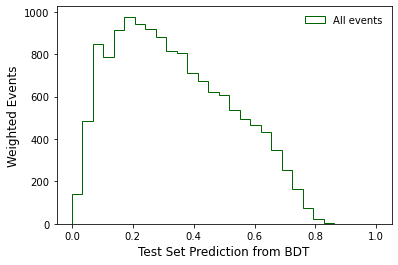

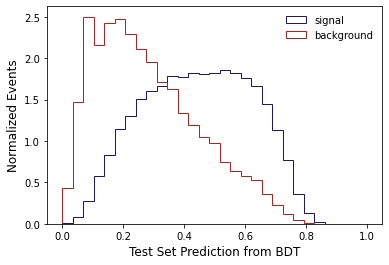

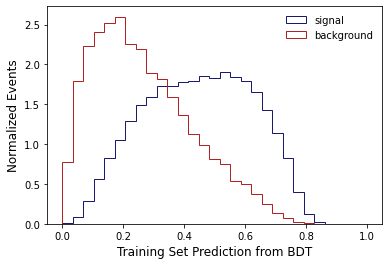

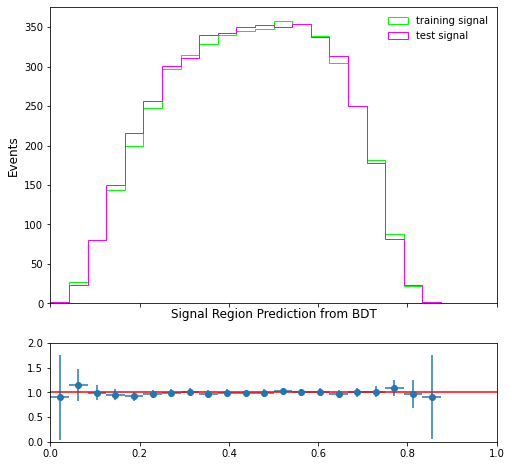

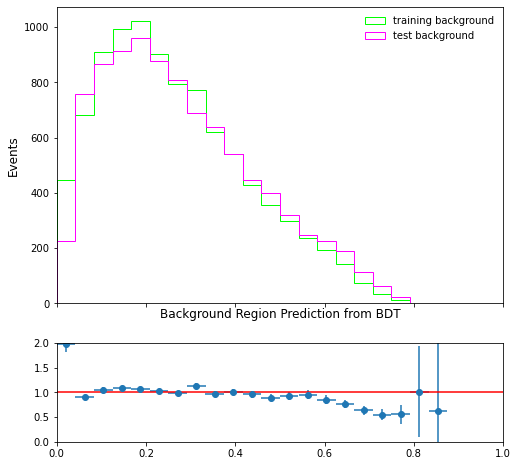

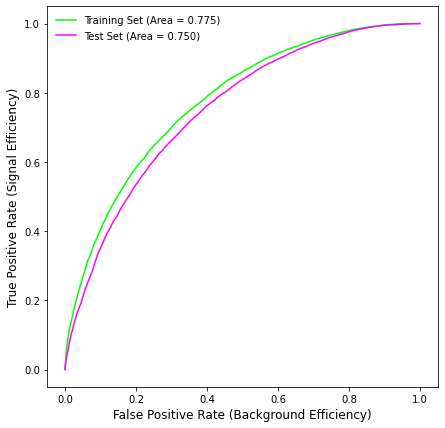

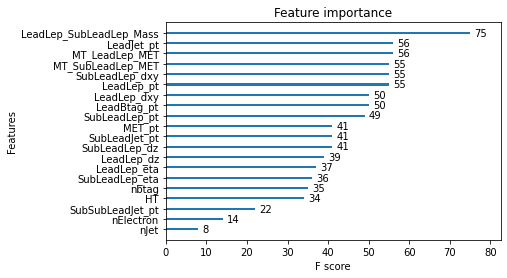

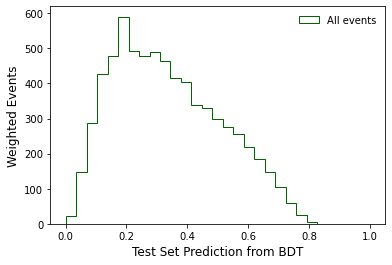

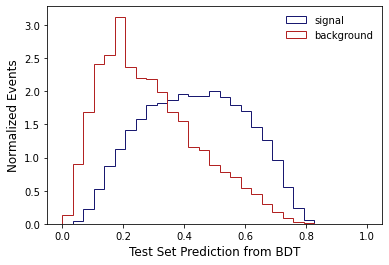

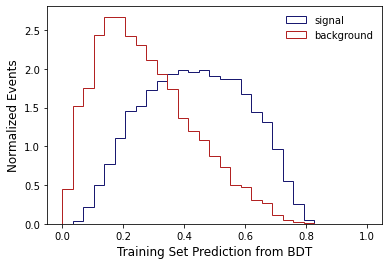

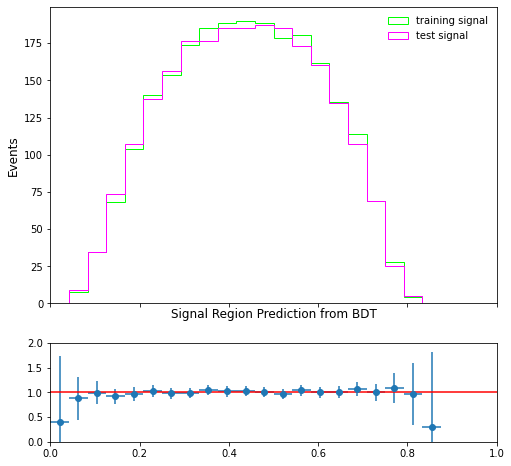

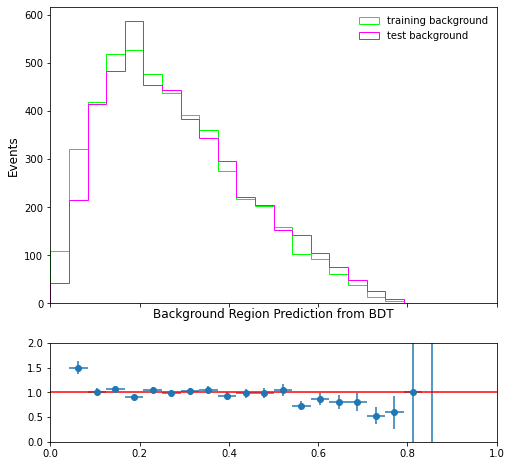

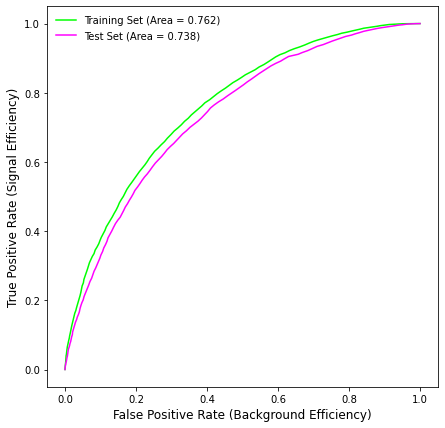

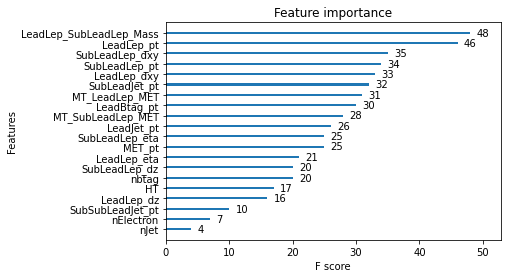

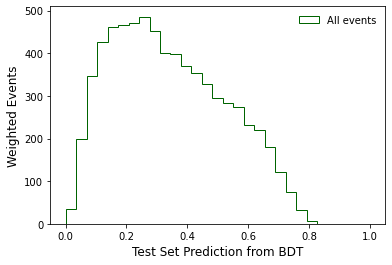

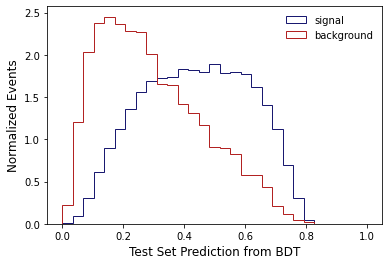

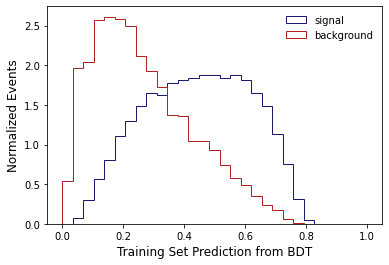

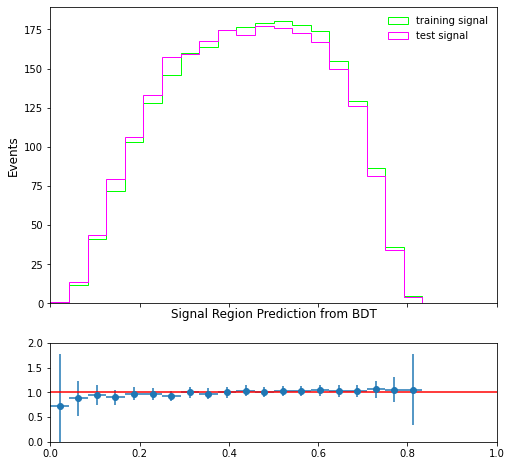

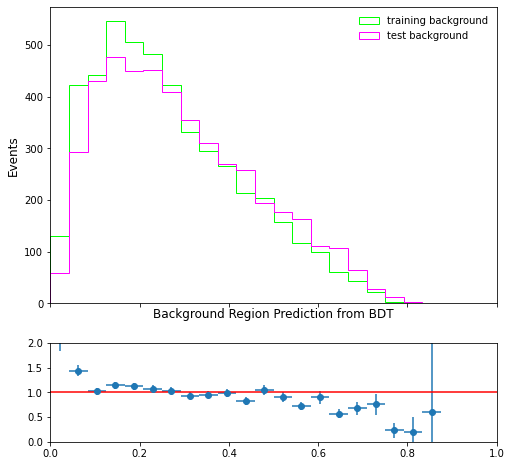

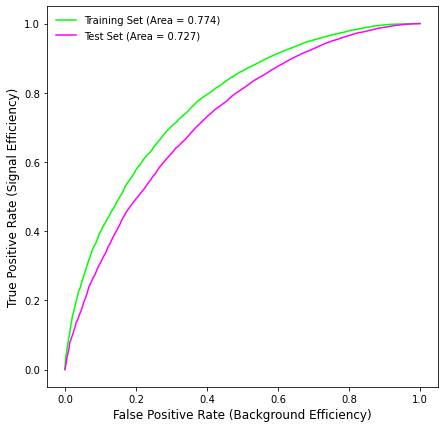

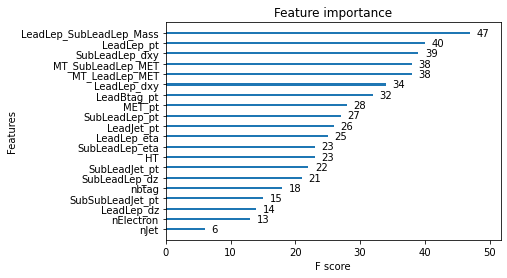

In [88]:
os.makedirs(output_dir + "Total", exist_ok=True)
os.makedirs(output_dir + "Dilep", exist_ok=True)
os.makedirs(output_dir + "Trilep", exist_ok=True)

gen_prediction_plots(booster, test, train, data_test, data_train, out_dir=output_dir+"Total/", savefig=True, plot=True)
gen_prediction_plots(dilep_booster, dilep_test, dilep_train, dilep_data_test, dilep_data_train, out_dir=output_dir+"Dilep/", savefig=True, plot=True)
gen_prediction_plots(trilep_booster, trilep_test, trilep_train, trilep_data_test, trilep_data_train, out_dir=output_dir+"Trilep/", savefig=True, plot=True)

### Generate Feature Plots for Signal/Background

In [89]:
labels = BDT_params[:(len(BDT_params)-1)]

bins_dict = { "Most_Forward_pt":np.linspace(10,200,30),
              "HT":np.linspace(80,1200,30),
              "LeadLep_eta":np.linspace(0,2.4,15),
              "MET_pt":np.linspace(0,300,30),
              "LeadLep_pt":np.linspace(10,200,30),
              "LeadLep_dxy":np.linspace(0,0.015,30),
              "LeadLep_dz":np.linspace(0,0.015,30),
              "SubLeadLep_pt":np.linspace(10,120,30),
              "SubLeadLep_eta":np.linspace(0,2.4,15),
              "SubLeadLep_dxy":np.linspace(0,0.015,30),
              "SubLeadLep_dz":np.linspace(0,0.015,30),
              "nJet":np.linspace(1.5,8.5,8),
              "LeadJet_pt":np.linspace(40,450,30),
              "SubLeadJet_pt":np.linspace(10,250,30),
              "SubSubLeadJet_pt":np.linspace(10,250,30),
              "nElectron":np.linspace(-0.5,4.5,6),
              "MT_LeadLep_MET":np.linspace(0,300,30),
              "MT_SubLeadLep_MET":np.linspace(0,300,30),
              "LeadBtag_pt":np.linspace(0,200,30),
              "nbtag":np.linspace(-0.5,3.5,5),
              "LeadLep_SubLeadLep_Mass":np.linspace(0, 350, 30)
            }

def gen_hist(data_test, label, out_dir=output_dir, savefig=False, plot=False):
    plt.figure(label, figsize=(6,6));
    bins = bins_dict[label]
    values_signal = data_test[label][data_test.Label == 's']
    values_background = data_test[label][data_test.Label == 'b']
    if label not in ["nJet, nbtag, nElectron"]:
        plt.hist(np.clip(values_signal, bins[0], bins[-1]),bins=bins_dict[label],
                 histtype='step',color='midnightblue',label='signal', density=True);
        plt.hist(np.clip(values_background, bins[0], bins[-1]),bins=bins_dict[label],
                 histtype='step',color='firebrick',label='background', density=True);
    else:
        plt.hist(values_signal, bins=bins_dict[label],
                 histtype='step',color='midnightblue',label='signal', density=True);
        plt.hist(values_background,bins=bins_dict[label],
                 histtype='step',color='firebrick',label='background', density=True);

    log_params = ["SubLeadLep_dxy", "SubLeadLep_dz", "LeadLep_dxy", "LeadLep_dz"]
    if label in log_params:
        plt.yscale("log")
    plt.xlabel(label,fontsize=12);
    plt.ylabel('Normalized Counts',fontsize=12);
    plt.legend(frameon=False);
    if savefig:
        plt.savefig(out_dir + "histograms/{}.pdf".format(label))
    if plot:
        plt.draw()
    else:
        plt.close()
    
flag_run_cell = True
if flag_run_cell:
    os.makedirs(output_dir + "Total/histograms", exist_ok=True)
    os.makedirs(output_dir + "Dilep/histograms", exist_ok=True)
    os.makedirs(output_dir + "Trilep/histograms", exist_ok=True)
    for label in labels:
        gen_hist(data_test, label, out_dir=output_dir+"Total/", savefig=True, plot=False)
        gen_hist(dilep_data_test, label, out_dir=output_dir+"Dilep/", savefig=True, plot=False)
        gen_hist(trilep_data_test, label, out_dir=output_dir+"Trilep/", savefig=True, plot=False)

In [90]:
dict_HCT_regions = {}
dict_HUT_regions = {}
if flag_load_babies:
    dict_SR = {"HCT":dict_HCT_regions, "HUT":dict_HUT_regions}
    for s in ["HCT", "HUT"]:
        if s == "HUT":
            BDT_signal = BDT_analysis.load_category("signal_tuh")
        elif s == "HCT":
            BDT_signal = BDT_analysis.load_category("signal_tch")
        BDT_flips = BDT_analysis.load_category("flips_mc")
        BDT_fakes = BDT_analysis.load_category("fakes_mc")
        BDT_rares = BDT_analysis.load_category("rares")
        dict_SR[s]["signal"] = BDT_signal
        dict_SR[s]["fakes"] = BDT_fakes
        dict_SR[s]["flips"] = BDT_flips
        dict_SR[s]["rares"] = BDT_rares
    
else:
    dict_SR = {"HCT":dict_HCT_regions, "HUT":dict_HUT_regions}
    for s in ["HCT", "HUT"]:
        BDT_signal, BDT_fakes = get_SR_BR(s, base_dir, version, year, BDT_params, background_category="fakes", flag_match_yields=False)[:2]
        BDT_flips = get_SR_BR(s, base_dir, version, year, BDT_params, background_category="flips", flag_match_yields=False, gen_signal=False)[1]
        BDT_rares = get_SR_BR(s, base_dir, version, year, BDT_params, background_category="rares", flag_match_yields=False, gen_signal=False)[1]


### Generate Datacards for Comparison
To do this, we need to make a full dataset (no more splitting into train/test).

In [91]:
def gen_debug_datacard(booster, baby_dir, outdir="/home/users/cmcmahon/CMSSW_10_2_9/src/tW_scattering/postProcessing/datacard_comparison/datacards/"):
    #makes a datacard with 1 BDT bin (for comparing yields between different datacards)
    #this was a debug tool to prepare a datacard, and then run datacard_comparison.ipynb afterwards
    dict_SR = {"HCT":dict_HCT_regions, "HUT":dict_HUT_regions}
    for s in ["HCT", "HUT"]:
        if s == "HUT":
            BDT_signal = load_category("signal_tuh", baby_dir)
        elif s == "HCT":
            BDT_signal = load_category("signal_tch", baby_dir)
        BDT_flips = load_category("flips_mc", baby_dir)
        BDT_fakes = load_category("fakes_mc", baby_dir)
        BDT_rares = load_category("rares", baby_dir)
        dict_SR[s]["signal"] = BDT_signal
        dict_SR[s]["fakes"] = BDT_fakes
        dict_SR[s]["flips"] = BDT_flips
        dict_SR[s]["rares"] = BDT_rares
    BDT_bins = np.linspace(0, 1, 2) 
    for s in ["HCT", "HUT"]:
        yield_dict = {}
        BDT_fakes = dict_SR[s]["fakes"]
        BDT_flips = dict_SR[s]["flips"]
        BDT_rares = dict_SR[s]["rares"]
        BDT_signal = dict_SR[s]["signal"]
        feature_names = BDT_fakes.columns[1:-2]  #full_data
        fakes_weights = BDT_fakes.weight
        flips_weights = BDT_flips.weight
        rares_weights = BDT_rares.weight
        signal_weights = BDT_signal.weight / 100.0
        BDT_fakes['Label'] = BDT_fakes.Label.astype('category')
        BDT_flips['Label'] = BDT_flips.Label.astype('category')
        BDT_rares['Label'] = BDT_rares.Label.astype('category')
        BDT_signal['Label'] = BDT_signal.Label.astype('category')
        fakes_dmatrix = xgb.DMatrix(data=BDT_fakes[feature_names],label=BDT_fakes.Label.cat.codes, missing=-999.0,feature_names=feature_names)
        flips_dmatrix = xgb.DMatrix(data=BDT_flips[feature_names],label=BDT_flips.Label.cat.codes, missing=-999.0,feature_names=feature_names)
        rares_dmatrix = xgb.DMatrix(data=BDT_rares[feature_names],label=BDT_rares.Label.cat.codes, missing=-999.0,feature_names=feature_names)
        signal_dmatrix = xgb.DMatrix(data=BDT_signal[feature_names],label=BDT_signal.Label.cat.codes, missing=-999.0,feature_names=feature_names)
        fakes_predictions = booster.predict(fakes_dmatrix)
        flips_predictions = booster.predict(flips_dmatrix)
        rares_predictions = booster.predict(rares_dmatrix)
        signal_predictions = booster.predict(signal_dmatrix)
        signal_digitized = np.digitize(signal_predictions, BDT_bins)
        flips_digitized = np.digitize(flips_predictions, BDT_bins)
        fakes_digitized = np.digitize(fakes_predictions, BDT_bins)
        rares_digitized = np.digitize(rares_predictions, BDT_bins)
        for b in range(1, len(BDT_bins)):
            background_sum = 0
            for category in ["signal", "fakes", "flips", "rares"]:
                #breakpoint()
                yield_name = "bin_{0}_{1}".format(b-1, category)
                if category=="signal":
                    tmp_yield = np.sum(signal_weights[signal_digitized==b])
                    tmp_BDT_hist = Hist1D(signal_predictions, bins=BDT_bins, weights=signal_weights, overflow=False)
                elif category =="flips":
                    tmp_yield = np.sum(flips_weights[flips_digitized==b])
                    tmp_BDT_hist = Hist1D(flips_predictions, bins=BDT_bins, weights=flips_weights, overflow=False)
                elif category == "fakes":
                    tmp_yield = np.sum(fakes_weights[fakes_digitized==b])
                    tmp_BDT_hist = Hist1D(fakes_predictions, bins=BDT_bins, weights=fakes_weights, overflow=False)
                elif category == "rares":
                    tmp_yield = np.sum(rares_weights[rares_digitized==b])
                    tmp_BDT_hist = Hist1D(rares_predictions, bins=BDT_bins, weights=rares_weights, overflow=False)
                tmp_error = tmp_BDT_hist.errors[b-1]
                if tmp_yield > 0:
                    yield_dict[yield_name] = tmp_yield
                    yield_dict[yield_name+"_error"] = tmp_error
                elif tmp_yield <=0:
                    yield_dict[yield_name] = 0.01
                    yield_dict[yield_name+"_error"] = 0.0
                if category != "signal":
                    background_sum += tmp_yield
            yield_dict["bin_{0}_Total_Background".format(b-1)] = background_sum
        postProcessing.makeCards.make_BDT_datacard(yield_dict, BDT_bins, s, 2018,  outdir)
        return dict_SR, yield_dict 

In [92]:
def make_dmatrix(df):
    feature_names = df.columns[1:-2]
    df["Label"] = df.Label.astype("category")
    return xgb.DMatrix(data=df[feature_names],label=df.Label.cat.codes, missing=-999.0,feature_names=feature_names)

### Compare Background Categories
Fakes, flips, rares, and signal. We also will scale the total yields of each category to match the total yields in Kaitlin's datacards.

[09:55:07] WARNING: ../src/learner.cc:1238: Empty dataset at worker: 0


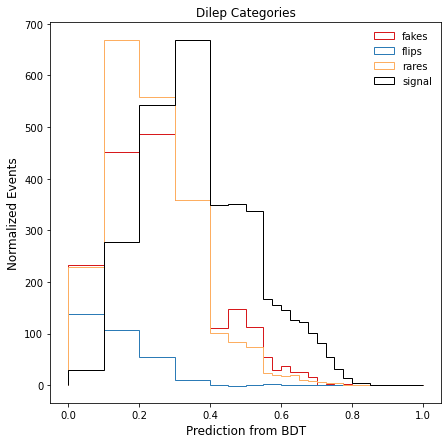

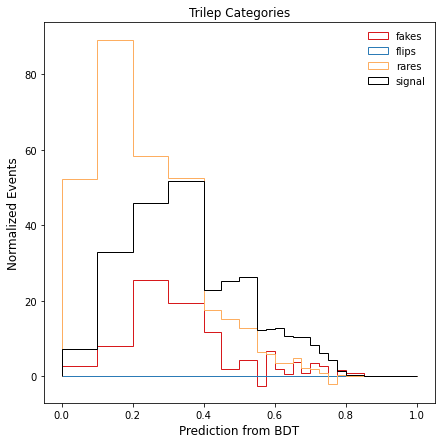

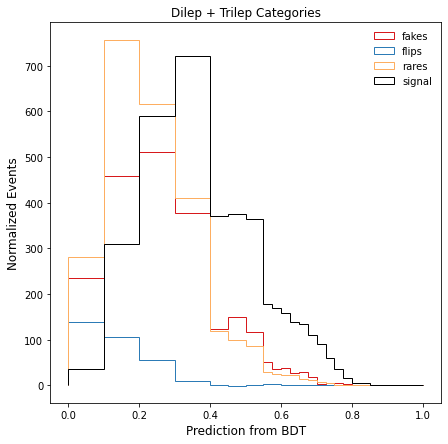

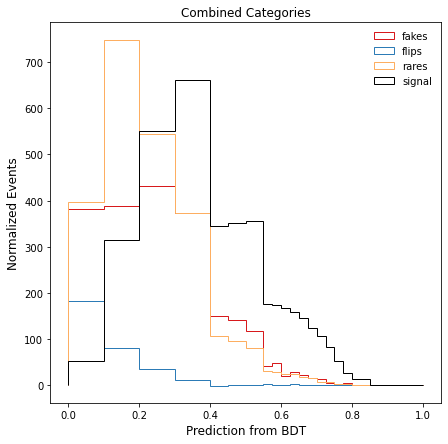

In [93]:
#ratio_dict = compare_datacards.gen_datacard_ratios()
dilep_dict = {
    "signal":pd.concat([BDT_analysis.load_category(s, dilep_baby_dir) for s in ["signal_tch", "signal_tuh"]], axis=0),
    "flips":BDT_analysis.load_category("flips_mc", dilep_baby_dir),
    "fakes":BDT_analysis.load_category("fakes_mc", dilep_baby_dir),
    "rares":BDT_analysis.load_category("rares", dilep_baby_dir)
}
trilep_dict = {
     "signal":pd.concat([BDT_analysis.load_category(s, trilep_baby_dir) for s in ["signal_tch", "signal_tuh"]], axis=0),
     "flips":BDT_analysis.load_category("flips_mc", trilep_baby_dir),
     "fakes":BDT_analysis.load_category("fakes_mc", trilep_baby_dir),
     "rares":BDT_analysis.load_category("rares", trilep_baby_dir)
}
combined_dict = {
    "signal":pd.concat([dilep_dict["signal"], trilep_dict["signal"]], axis=0),
    "fakes":pd.concat([dilep_dict["fakes"], trilep_dict["fakes"]], axis=0),
    "flips":dilep_dict["flips"],
    "rares":pd.concat([dilep_dict["rares"], trilep_dict["rares"]], axis=0)
}

dilep_prediction_dict = {
    "signal":dilep_booster.predict(make_dmatrix(dilep_dict["signal"])),
    "fakes":dilep_booster.predict(make_dmatrix(dilep_dict["fakes"])),
    "flips":dilep_booster.predict(make_dmatrix(dilep_dict["flips"])),
    "rares":dilep_booster.predict(make_dmatrix(dilep_dict["rares"]))
}
trilep_prediction_dict = {
    "signal":trilep_booster.predict(make_dmatrix(trilep_dict["signal"])),
    "fakes":trilep_booster.predict(make_dmatrix(trilep_dict["fakes"])),
    "flips":trilep_booster.predict(make_dmatrix(trilep_dict["flips"])),
    "rares":trilep_booster.predict(make_dmatrix(trilep_dict["rares"]))
}
dilep_trilep_prediction_dict = {
    "signal":np.concatenate([dilep_prediction_dict["signal"], trilep_prediction_dict["signal"]]),
    "fakes":np.concatenate([dilep_prediction_dict["fakes"], trilep_prediction_dict["fakes"]]),
    "flips":dilep_prediction_dict["flips"], #no flips in the trilep region
    "rares":np.concatenate([dilep_prediction_dict["rares"], trilep_prediction_dict["rares"]])
}
total_prediction_dict = {
    "signal":booster.predict(make_dmatrix(combined_dict["signal"])),
    "fakes":booster.predict(make_dmatrix(combined_dict["fakes"])),
    "flips":booster.predict(make_dmatrix(combined_dict["flips"])),
    "rares":booster.predict(make_dmatrix(combined_dict["rares"]))
}

def plot_categories(df_dict, prediction_dict, title="", out_dir=output_dir):
    BDT_signal = df_dict["signal"]
    BDT_fakes = df_dict["fakes"]
    BDT_flips = df_dict["flips"]
    BDT_rares = df_dict["rares"]
    feature_names = BDT_fakes.columns[1:-2]
    BDT_fakes['Label'] = BDT_fakes.Label.astype('category')
    BDT_flips['Label'] = BDT_flips.Label.astype('category')
    BDT_rares['Label'] = BDT_rares.Label.astype('category')
    BDT_signal['Label'] = BDT_signal.Label.astype('category')
    fakes_predictions = prediction_dict["fakes"]
    flips_predictions = prediction_dict["flips"]
    rares_predictions = prediction_dict["rares"]
    signal_predictions = prediction_dict["signal"]
    plt.figure(figsize=(7,7));
    tmp_bins = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.45, 0.50, 0.55, 0.575, 0.60, 0.625, 0.65, 0.675, 0.70, 0.725, 0.75, 0.775, 0.8, 0.85, 1.0])
    plt.hist(fakes_predictions,bins=tmp_bins,histtype='step',color='#d7191c',label='fakes', weights=BDT_fakes.weight)#, density=True);
    plt.hist(flips_predictions,bins=tmp_bins,histtype='step',color='#2c7bb6',label='flips', weights=BDT_flips.weight)#, density=True);
    plt.hist(rares_predictions,bins=tmp_bins,histtype='step',color='#fdae61',label='rares', weights=BDT_rares.weight)#, density=True);
    plt.hist(signal_predictions,bins=tmp_bins,histtype='step',color='black',label='signal', weights=BDT_signal.weight/100)#, density=True);

    # make the plot readable
    plt.xlabel('Prediction from BDT',fontsize=12);
    plt.ylabel('Normalized Events',fontsize=12);
    plt.legend(frameon=False);
    plt.title(title)
    os.makedirs(out_dir, exist_ok=True)
    plt.savefig(out_dir + "Background_Categories.pdf")

plot_categories(dilep_dict, dilep_prediction_dict, "Dilep Categories", out_dir=output_dir+"Dilep/")
plot_categories(trilep_dict, trilep_prediction_dict, "Trilep Categories",  out_dir=output_dir+"Trilep/")
plot_categories(combined_dict, dilep_trilep_prediction_dict, "Dilep + Trilep Categories", out_dir=output_dir+"Dilep_Trilep/")
plot_categories(combined_dict, total_prediction_dict, "Combined Categories", out_dir=output_dir+"Combined/")

### Make a Datacard with BDT Binning

In [94]:
def gen_datacard(df_dict, prediction_dict, signal_name, out_dir="/home/users/cmcmahon/public_html/BDT/datacards/", y=2018):
    yield_dict = {}
    BDT_signal = df_dict["signal"]
    BDT_fakes = df_dict["fakes"]
    BDT_flips = df_dict["flips"]
    BDT_rares = df_dict["rares"]
    BDT_bins =  np.array([0.3, 0.4, 0.45, 0.50, 0.55, 0.575, 0.60, 0.625, 0.65, 0.675, 0.70,  1.0])
    feature_names = BDT_fakes.columns[1:-2]  #full_data
    fakes_weights = BDT_fakes.weight 
    flips_weights = BDT_flips.weight
    rares_weights = BDT_rares.weight 
    signal_weights = BDT_signal.weight / 100.0
    signal_predictions = prediction_dict["signal"]
    fakes_predictions = prediction_dict["fakes"]
    flips_predictions = prediction_dict["flips"]
    rares_predictions = prediction_dict["rares"]
    signal_digitized = np.digitize(signal_predictions, BDT_bins)
    flips_digitized = np.digitize(flips_predictions, BDT_bins)
    fakes_digitized = np.digitize(fakes_predictions, BDT_bins)
    rares_digitized = np.digitize(rares_predictions, BDT_bins)
    for b in range(1, len(BDT_bins)):
        background_sum = 0
        for category in ["signal", "fakes", "flips", "rares"]:
            yield_name = "bin_{0}_{1}".format(b-1, category)
            if category=="signal":
                tmp_yield = np.sum(signal_weights[signal_digitized==b])
                tmp_BDT_hist = Hist1D(signal_predictions, bins=BDT_bins, weights=signal_weights, overflow=False)
            elif category =="flips":
                tmp_yield = np.sum(flips_weights[flips_digitized==b])
                tmp_BDT_hist = Hist1D(flips_predictions, bins=BDT_bins, weights=flips_weights, overflow=False)
            elif category == "fakes":
                tmp_yield = np.sum(fakes_weights[fakes_digitized==b])
                tmp_BDT_hist = Hist1D(fakes_predictions, bins=BDT_bins, weights=fakes_weights, overflow=False)
            elif category == "rares":
                tmp_yield = np.sum(rares_weights[rares_digitized==b])
                tmp_BDT_hist = Hist1D(rares_predictions, bins=BDT_bins, weights=rares_weights, overflow=False)
            tmp_error = tmp_BDT_hist.errors[b-1]
            if tmp_yield > 0:
                yield_dict[yield_name] = tmp_yield
                yield_dict[yield_name+"_error"] = tmp_error
            elif tmp_yield <=0:
                yield_dict[yield_name] = 0.01
                yield_dict[yield_name+"_error"] = 0.0
            if category != "signal":
                background_sum += tmp_yield
        yield_dict["bin_{0}_Total_Background".format(b-1)] = background_sum
    output_path = out_dir + signal_name + "/"
    os.makedirs(output_path, exist_ok=True)
    postProcessing.makeCards.make_BDT_datacard(yield_dict, BDT_bins, s, y, output_path)

HCT_dict = combined_dict.copy()
HUT_dict = combined_dict.copy()
HCT_dict["signal"] = pd.concat([BDT_analysis.load_category("signal_tch", dilep_baby_dir), BDT_analysis.load_category("signal_tch", trilep_baby_dir)], axis=0)
HUT_dict["signal"] = pd.concat([BDT_analysis.load_category("signal_tuh", dilep_baby_dir), BDT_analysis.load_category("signal_tuh", trilep_baby_dir)], axis=0)

HCT_dilep_trilep_prediction_dict = dilep_trilep_prediction_dict.copy()
HUT_dilep_trilep_prediction_dict = dilep_trilep_prediction_dict.copy()
HCT_dilep_signal_prediction = dilep_booster.predict(make_dmatrix(BDT_analysis.load_category("signal_tch", dilep_baby_dir)))
HCT_trilep_signal_prediction = dilep_booster.predict(make_dmatrix(BDT_analysis.load_category("signal_tch", trilep_baby_dir)))
HUT_dilep_signal_prediction = dilep_booster.predict(make_dmatrix(BDT_analysis.load_category("signal_tuh", dilep_baby_dir)))
HUT_trilep_signal_prediction = dilep_booster.predict(make_dmatrix(BDT_analysis.load_category("signal_tuh", trilep_baby_dir)))
HCT_dilep_trilep_prediction_dict["signal"] = np.concatenate([HCT_dilep_signal_prediction, HCT_trilep_signal_prediction])
HUT_dilep_trilep_prediction_dict["signal"] = np.concatenate([HUT_dilep_signal_prediction, HUT_trilep_signal_prediction])

HCT_combined_prediction_dict = total_prediction_dict.copy()
HUT_combined_prediction_dict = total_prediction_dict.copy()
HCT_combined_prediction_dict["signal"] = booster.predict(make_dmatrix(HCT_dict["signal"]))
HUT_combined_prediction_dict["signal"] = booster.predict(make_dmatrix(HUT_dict["signal"]))

combined_predictions = {
    "HCT":HCT_combined_prediction_dict,
    "HUT":HUT_combined_prediction_dict
}
dilep_trilep_predictions = {
    "HCT":HCT_dilep_trilep_prediction_dict,
    "HUT":HUT_dilep_trilep_prediction_dict
}
combined_dict = {
    "HCT":HCT_dict,
    "HUT":HUT_dict
}
for s in ["HCT", "HUT"]:
    gen_datacard(combined_dict[s], dilep_trilep_predictions[s], s, out_dir="/home/users/cmcmahon/public_html/BDT/datacards/Dilep_Trilep/", y=year)
    gen_datacard(combined_dict[s], combined_predictions[s], s, out_dir="/home/users/cmcmahon/public_html/BDT/datacards/Combined/", y=year)

got yields and stat errors
defined output dataframe
filled stat uncertainties
filled syst uncertainties
got yields and stat errors
defined output dataframe
filled stat uncertainties
filled syst uncertainties
got yields and stat errors
defined output dataframe
filled stat uncertainties
filled syst uncertainties
got yields and stat errors
defined output dataframe
filled stat uncertainties
filled syst uncertainties


In [13]:
#look at the different background categories (fakes, flips and rares)
if flag_load_babies:
    tot_BDT_signal = pd.concat([dict_SR["HCT"]["signal"], dict_SR["HUT"]["signal"]], axis=0)
    tot_BDT_flips = dict_SR["HCT"]["flips"]
    tot_BDT_fakes = dict_SR["HCT"]["fakes"]
    tot_BDT_rares = dict_SR["HCT"]["rares"]
    feature_names = tot_BDT_fakes.columns[1:-2] # we skip the first and last two columns because they are the ID, weight, and label    
else:
    tot_BDT_signal, tot_BDT_fakes = get_SR_BR(signal_name, base_dir, version, year, BDT_params, background_category="fakes", flag_match_yields=False)[:2]
    tot_BDT_flips = get_SR_BR(signal_name, base_dir, version, year, BDT_params, background_category="flips", flag_match_yields=False, gen_signal=False)[1]
    tot_BDT_rares = get_SR_BR(signal_name, base_dir, version, year, BDT_params, background_category="rares", flag_match_yields=False, gen_signal=False)[1]
    feature_names = tot_BDT_fakes.columns[1:-2] # we skip the first and last two columns because they are the ID, weight, and label

### Export BDT to a Customized XML File
This puts the BDT into a format that can be processed by the TMVA library in ROOT. See [here](https://github.com/cjmcmahon1/FCNCAnalysis/blob/main/analysis/helpers/BDT/booster.h) for how to turn this into a TMVA booster.

In [69]:
import re
import xml.etree.cElementTree as ET
regex_float_pattern = r'[-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?'

def build_tree(xgtree, base_xml_element, var_indices):
    parent_element_dict = {'0':base_xml_element}
    pos_dict = {'0':'s'}
    for line in xgtree.split('\n'):
        if not line: continue
        if ':leaf=' in line:
            #leaf node
            result = re.match(r'(\t*)(\d+):leaf=({0})$'.format(regex_float_pattern), line)
            if not result:
                print(line)
            depth = result.group(1).count('\t')
            inode = result.group(2)
            res = result.group(3)
            node_elementTree = ET.SubElement(parent_element_dict[inode], "Node", pos=str(pos_dict[inode]),
                                             depth=str(depth), NCoef="0", IVar="-1", Cut="0.0e+00", cType="1", res=str(res), rms="0.0e+00", purity="0.0e+00", nType="-99")
        else:
            #\t\t3:[var_topcand_mass<138.19] yes=7,no=8,missing=7
            result = re.match(r'(\t*)([0-9]+):\[(?P<var>.+)<(?P<cut>{0})\]\syes=(?P<yes>\d+),no=(?P<no>\d+)'.format(regex_float_pattern),line)
            if not result:
                print(line)
            depth = result.group(1).count('\t')
            inode = result.group(2)
            var = result.group('var')
            cut = result.group('cut')
            lnode = result.group('yes')
            rnode = result.group('no')
            pos_dict[lnode] = 'l'
            pos_dict[rnode] = 'r'
            node_elementTree = ET.SubElement(parent_element_dict[inode], "Node", pos=str(pos_dict[inode]),
                                             depth=str(depth), NCoef="0", IVar=str(var_indices[var]), Cut=str(cut),
                                             cType="1", res="0.0e+00", rms="0.0e+00", purity="0.0e+00", nType="0")
            parent_element_dict[lnode] = node_elementTree
            parent_element_dict[rnode] = node_elementTree
            
def convert_model(model, input_variables, output_xml):
    NTrees = len(model)
    var_list = input_variables
    var_indices = {}
    
    # <MethodSetup>
    MethodSetup = ET.Element("MethodSetup", Method="BDT::BDT")

    # <Variables>
    Variables = ET.SubElement(MethodSetup, "Variables", NVar=str(len(var_list)))
    for ind, val in enumerate(var_list):
        name = val[0]
        var_type = val[1]
        var_indices[name] = ind
        Variable = ET.SubElement(Variables, "Variable", VarIndex=str(ind), Type=val[1], 
            Expression=name, Label=name, Title=name, Unit="", Internal=name, 
            Min="0.0e+00", Max="0.0e+00")

    # <GeneralInfo>
    GeneralInfo = ET.SubElement(MethodSetup, "GeneralInfo")
    Info_Creator = ET.SubElement(GeneralInfo, "Info", name="Creator", value="xgboost2TMVA")
    Info_AnalysisType = ET.SubElement(GeneralInfo, "Info", name="AnalysisType", value="Classification")

    # <Options>
    Options = ET.SubElement(MethodSetup, "Options")
    Option_NodePurityLimit = ET.SubElement(Options, "Option", name="NodePurityLimit", modified="No").text = "5.00e-01"
    Option_BoostType = ET.SubElement(Options, "Option", name="BoostType", modified="Yes").text = "Grad"
    
    # <Weights>
    Weights = ET.SubElement(MethodSetup, "Weights", NTrees=str(NTrees), AnalysisType="1")
    
    for itree in range(NTrees):
        BinaryTree = ET.SubElement(Weights, "BinaryTree", type="DecisionTree", boostWeight="1.0e+00", itree=str(itree))
        build_tree(model[itree], BinaryTree, var_indices)
        
    tree = ET.ElementTree(MethodSetup)
    tree.write(output_xml)
    # format it with 'xmllint --format'
#print(feature_names)
input_variables = []
for var in range(len(feature_names)):
    input_variables.append([feature_names[var]])
    input_variables[var].append("F")
#print(input_variables)
#convert_model(booster.get_dump(), input_variables = input_variables, output_xml = "./test.xml")
convert_model(booster.get_dump(), input_variables = input_variables, output_xml = "/home/users/cmcmahon/fcnc/ana/analysis/helpers/BDT/BDT.xml")

### Manually Evaluate BDT for Different Parameters (useful to compare against Kaitlin's Looper)

In [161]:
testing_df = pd.DataFrame({
    "Most_Forward_pt":np.array([71.75]),
    "HT": np.array([112.438]),
    "LeadLep_eta":np.array([0.237823]),
    "LeadLep_pt":np.array([69.9879]),
    "LeadLep_dxy":np.array([0.00178814]),
    "LeadLep_dz":np.array([0.0036068]),
    "SubLeadLep_pt":np.array([44.2208]),
    "SubLeadLep_eta": np.array([0.097702]),
    "SubLeadLep_dxy":np.array([0.00188828]),
    "SubLeadLep_dz":np.array([0.00151634]),
    "nJet":np.array([2.0]),
    "nbtag":np.array([0.0]),
    "LeadJet_pt":np.array([71.75]),
    "SubLeadJet_pt":np.array([40.6875]),
    "SubSubLeadJet_pt":np.array([0]),
    "nElectron":np.array([1]),
    "MET_pt":np.array([42.583]),
    "LeadBtag_pt":np.array([0]),
    "MT_LeadLep_MET":np.array([100.811]),
    "MT_SubLeadLep_MET":np.array([5.78284]),
    "LeadLep_SubLeadLep_Mass":np.array([101.405])
})
testing_dmatrix = xgb.DMatrix(data=testing_df[feature_names], missing=-999.0,feature_names=feature_names)
print(booster.predict(testing_dmatrix))

[0.34334102]


In [192]:
flag_debug_yields=False
if flag_debug_yields:
    year=2018
    BDT_params = ["Most_Forward_pt",
                  "HT",
                  "LeadLep_eta",
                  "LeadLep_pt",
                  "LeadLep_dxy",
                  "LeadLep_dz",
                  "SubLeadLep_pt",
                  "SubLeadLep_eta",
                  "SubLeadLep_dxy",
                  "SubLeadLep_dz",
                  "nJet",
                  "nbtag",
                  "LeadJet_pt",
                  "SubLeadJet_pt",
                  "SubSubLeadJet_pt",
                  "nElectron",
                  "MET_pt",
                  "LeadBtag_pt",
                  "MT_LeadLep_MET",
                  "MT_SubLeadLep_MET",
                  "LeadLep_SubLeadLep_Mass",
                  "weight"]
    version = "fcnc_v10_SRonly_11june2021"
    base_dir = "/nfs-7/userdata/ksalyer/fcnc/fcnc_v10_SRonly_11june2021/2018/"
    remove_files = glob.glob(base_dir + "*data.root") + glob.glob(base_dir + "tt[0-9]lep.root") + [base_dir + "ww.root"]
    debug_files = glob.glob(base_dir + "*.root")
    [debug_files.remove(r) for r in remove_files]
    debug_dict = {}
    for f in debug_files:
        debug_dict[f] = process_file(f, base_dir, BDT_params, version, year)

In [47]:
if flag_debug_yields:
    rares_remove = [base_dir + f for f in ["dyjets_m10-50.root", "dyjets_m50.root", "ww.root", "zg.root", "ttjets.root", "wjets.root", "ttg_1lep.root", "tw_dilep.root"]]
    rares_remove += glob.glob(base_dir + "*hut*.root") + glob.glob(base_dir + "*hct*.root") + glob.glob(base_dir + "*data.root") + glob.glob(base_dir + "tt[0-9]lep.root")
    rares_files = glob.glob(base_dir + "*.root")
    [rares_files.remove(r) for r in rares_remove]
    fakes_files = [base_dir + "ttjets.root", base_dir + "wjets.root", base_dir + "ttg_1lep.root"]
    flips_files = [base_dir + f for f in ["dyjets_m10-50.root", "dyjets_m50.root", "zg.root", "tw_dilep.root"]]
    signal_files = glob.glob(base_dir + "*hct*.root") + glob.glob(base_dir + "*hut*.root")
    for fname in debug_files:
        #breakpoint()
        process_name = fname[(fname.rfind('/')+1):(fname.rfind('.'))]
        tmp_tot = np.sum(debug_dict[fname].weight)
        if fname in rares_files:
            category = "rares"
        elif fname in fakes_files:
            category = "fakes"
        elif fname in flips_files:
            category = "flips"
        elif fname in signal_files:
            category = "signal"
        else:
            raise Exception("Could not categorize a file. {}".format(fname))
        print("Process: {0}".format(process_name).ljust(24) + "category: {0}".format(category).ljust(20) + "Total Yield = {0:.3f}".format(tmp_tot))

    tot_flips_yield = 0.
    print("\nFlips:")
    for fname in flips_files:
        process_name = fname[(fname.rfind('/')+1):(fname.rfind('.'))]
        tmp_tot = np.sum(debug_dict[fname].weight)
        tot_flips_yield += tmp_tot
        print("Process: {0}".format(process_name).ljust(24) + "Total Yield = {0:.3f}".format(tmp_tot))
    print("Total = {0:.3f}".format(tot_flips_yield))

    tot_fakes_yield = 0.
    print("\nFakes:")
    for fname in fakes_files:
        process_name = fname[(fname.rfind('/')+1):(fname.rfind('.'))]
        tmp_tot = np.sum(debug_dict[fname].weight)
        tot_fakes_yield += tmp_tot
        print("Process: {0}".format(process_name).ljust(24) + "Total Yield = {0:.3f}".format(tmp_tot))
    print("Total = {0:.3f}".format(tot_fakes_yield))

    tot_rares_yield = 0.
    print("\nRares:")
    for fname in rares_files:
        process_name = fname[(fname.rfind('/')+1):(fname.rfind('.'))]
        tmp_tot = np.sum(debug_dict[fname].weight)
        tot_rares_yield += tmp_tot
        print("Process: {0}".format(process_name).ljust(24) + "Total Yield = {0:.3f}".format(tmp_tot))
    print("Total = {0:.3f}".format(tot_rares_yield))

    tot_sig_yield = 0.
    print("\nSignal:")
    for fname in signal_files:
        process_name = fname[(fname.rfind('/')+1):(fname.rfind('.'))]
        tmp_tot = np.sum(debug_dict[fname].weight)
        tot_sig_yield += tmp_tot
        print("Process: {0}".format(process_name).ljust(24) + "Total Yield = {0:.3f}".format(tmp_tot))
    print("Total = {0:.3f}".format(tot_sig_yield))

In [38]:
#get yields of signal, fakes, flips, rares based on the BDT score

print(BDT_bins)
#BDT_bins = np.insert(BDT_bins, 0, 0.0) #insert 0 so that we have a bin from [0.0, 0.4]
signal_digitized = np.digitize(signal_predictions, BDT_bins)
flips_digitized = np.digitize(flips_predictions, BDT_bins)
fakes_digitized = np.digitize(fakes_predictions, BDT_bins)
rares_digitized = np.digitize(rares_predictions, BDT_bins)
yield_dict = {}
for b in range(1, len(BDT_bins)):
    background_sum = 0
    for category in ["signal", "fakes", "flips", "rares"]:
        #breakpoint()
        yield_name = "bin_{0}_{1}".format(b-1, category)
        if category=="signal":
            tmp_yield = np.sum(signal_weights[signal_digitized==b]) 
            tmp_BDT_hist = Hist1D(signal_predictions, bins=BDT_bins, weights=signal_weights, overflow=False)
        elif category =="flips":
            tmp_yield = np.sum(flips_weights[flips_digitized==b])
            tmp_BDT_hist = Hist1D(flips_predictions, bins=BDT_bins, weights=flips_weights, overflow=False)
        elif category == "fakes":
            tmp_yield = np.sum(fakes_weights[fakes_digitized==b])
            tmp_BDT_hist = Hist1D(fakes_predictions, bins=BDT_bins, weights=fakes_weights, overflow=False)
        elif category == "rares":
            tmp_yield = np.sum(rares_weights[rares_digitized==b])
            tmp_BDT_hist = Hist1D(rares_predictions, bins=BDT_bins, weights=rares_weights, overflow=False)
        tmp_error = tmp_BDT_hist.errors[b-1]
        yield_dict[yield_name] = tmp_yield
        yield_dict[yield_name+"_error"] = tmp_error
        if category != "signal":
            background_sum += tmp_yield
    yield_dict["bin_{0}_Total_Background".format(b-1)] = background_sum
#print(yield_dict)     

[0.4 0.5 0.6 0.7 0.8 0.9]


### Parameter Optimization

In [ ]:
signal_BDT_hist = Hist1D(signal_predictions, bins=BDT_bins, weights=signal_weights, overflow=False)
plt.figure(figsize=(6,6))
signal_BDT_hist.plot(errors=True)#plt.hist(signal_predictions,bins=BDT_bins,histtype='step',color='#d7191c',label='signal', weights=signal_weights)
plt.ylim([179, 184])
print(dir(signal_BDT_hist))
print(signal_BDT_hist.errors)

In [17]:
BDT_params = ["Most_Forward_pt",
              "HT",
              "LeadLep_eta",
              "LeadLep_pt",
              "LeadLep_dxy",
              "LeadLep_dz",
              "SubLeadLep_pt",
              "SubLeadLep_eta",
              "SubLeadLep_dxy",
              "SubLeadLep_dz",
              "nJet",
              "nbtag",
              "LeadJet_pt",
              "SubLeadJet_pt",
              "SubSubLeadJet_pt",
              "nElectron",
              "MET_pt",
              "LeadBtag_pt",
              "MT_LeadLep_MET",
              "MT_SubLeadLep_MET",
              "LeadLep_SubLeadLep_Mass",
              "weight"]

param = {}

# Booster parameters
param['eta']              = 1e-2 # learning rate (scaled by weight)
param['max_depth']        = 4  # maximum depth of a tree
param['subsample']        = 0.75 # fraction of events to train tree on
param['colsample_bytree'] = 0.75 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 800 # number of trees to make

booster_label = "800_trees_depth_4_abs"

signal_name = "HCT"
version = "fcnc_v6_SRonly_5may2021"
base_dir = "/nfs-7/userdata/ksalyer/fcnc/fcnc_v6_SRonly_5may2021/2018/"

comparison_dir = "/home/users/cmcmahon/public_html/BDT/compare_HCT_HUT/"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir + "histograms", exist_ok=True)

HCT_data = get_SR_BR("HCT", base_dir, version, 2018, BDT_params)[2]
HUT_data = get_SR_BR("HUT", base_dir, version, 2018, BDT_params)[2]
HCT_data_train, HCT_data_test = BDT_train_test_split(HCT_data)
HUT_data_train, HUT_data_test = BDT_train_test_split(HUT_data)
HCT_booster, HCT_train, HCT_test = gen_BDT("HCT", HCT_data_train, HCT_data_test, param, num_trees, comparison_dir, flag_load=True, verbose=False)
HUT_booster, HUT_train, HUT_test = gen_BDT("HUT", HUT_data_train, HUT_data_test, param, num_trees, comparison_dir, flag_load=True, verbose=False)

Processing:   0%|          | 0/2 [00:00<?, ?chunk/s]

Processing:   0%|          | 0/64 [00:00<?, ?chunk/s]

signal yield:4212.357440272155
background yield:1674.7059507619947
SR/BR yield ratio:2.5152818250604074
new signal yield:1674.7059507640229
new SR/BR yield ratio:1.000000000001211


Processing:   0%|          | 0/2 [00:00<?, ?chunk/s]

Processing:   0%|          | 0/64 [00:00<?, ?chunk/s]

signal yield:4107.623496544149
background yield:1674.7059507618733
SR/BR yield ratio:2.452743118680309
new signal yield:1674.7059507586534
new SR/BR yield ratio:0.9999999999980773
Size of data: (1349689, 24)
Number of events: 1349689
Number of columns: 24

List of features in dataset:
event
Most_Forward_pt
HT
LeadLep_eta
LeadLep_pt
LeadLep_dxy
LeadLep_dz
SubLeadLep_pt
SubLeadLep_eta
SubLeadLep_dxy
SubLeadLep_dz
nJet
nbtag
LeadJet_pt
SubLeadJet_pt
SubSubLeadJet_pt
nElectron
MET_pt
LeadBtag_pt
MT_LeadLep_MET
MT_SubLeadLep_MET
LeadLep_SubLeadLep_Mass
weight
Label
Number of signal events: 47928
Number of background events: 1301761
Fraction signal: 0.03551040276685963
Number of training samples: 674844
Number of testing samples: 674845

Number of signal events in training set: 24085
Number of background events in training set: 650759
Fraction signal: 0.03568972977458494
Size of data: (1350080, 24)
Number of events: 1350080
Number of columns: 24

List of features in dataset:
event
Most_Forwa

<ipython-input-18-3d1ece194a79>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(label, figsize=(6,6));


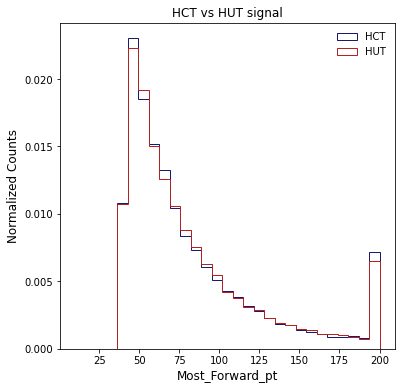

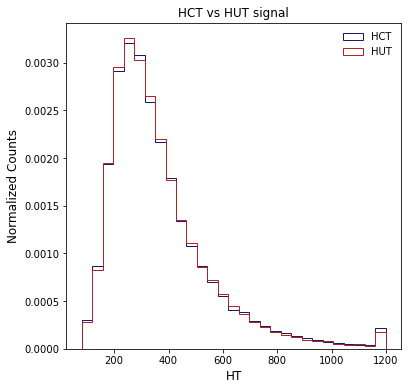

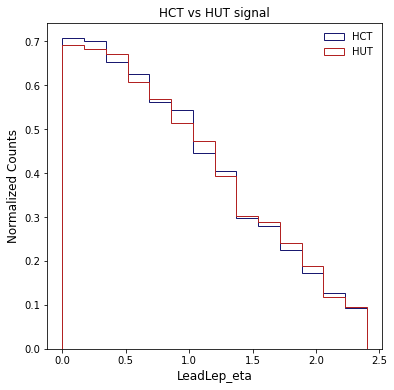

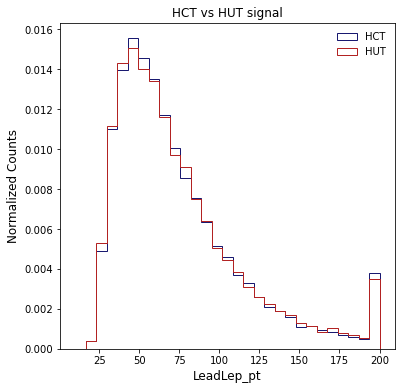

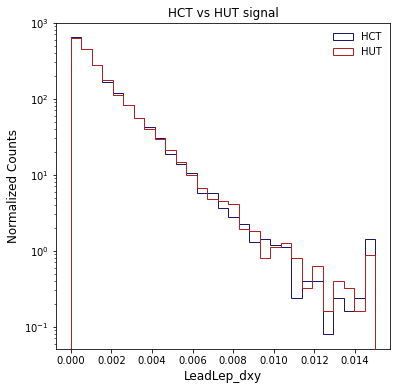

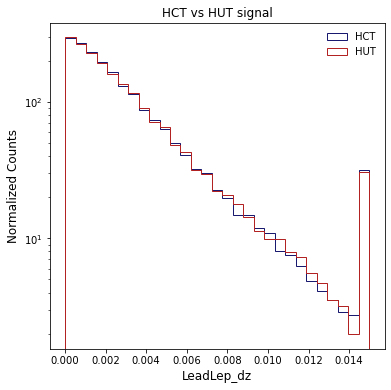

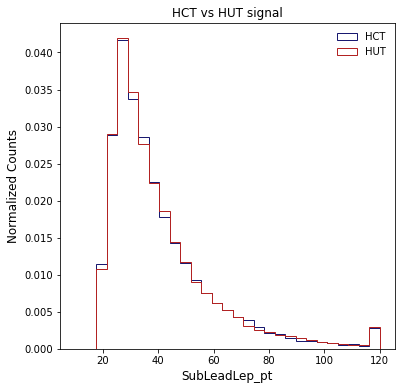

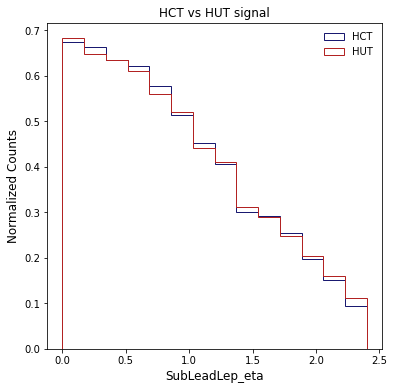

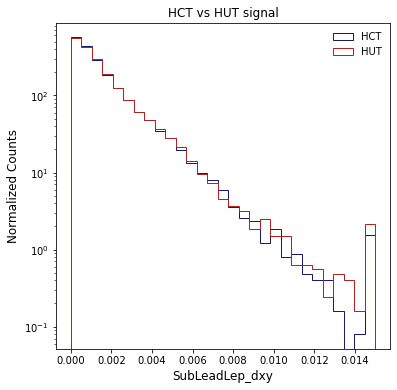

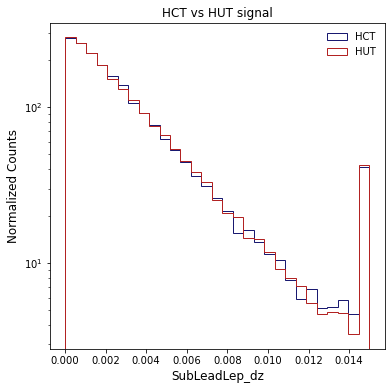

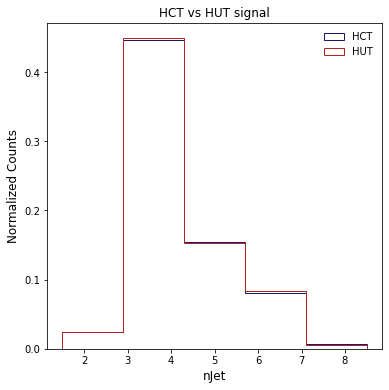

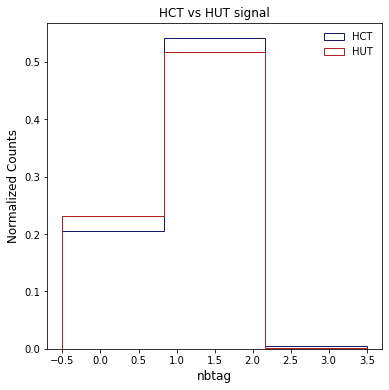

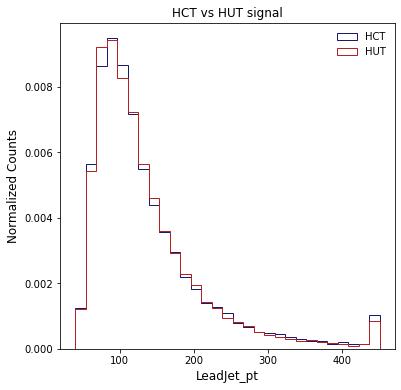

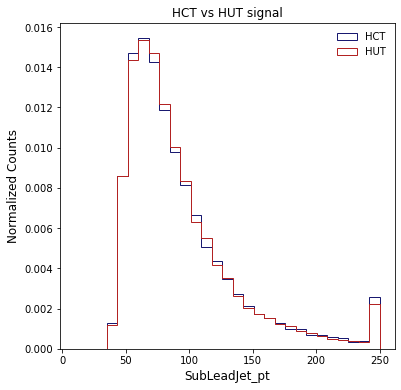

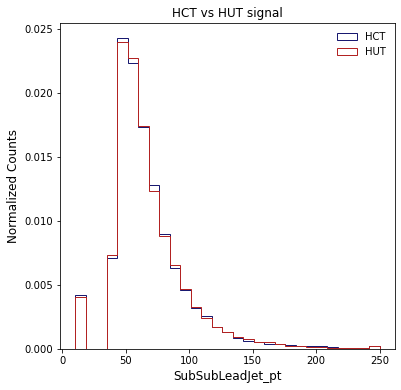

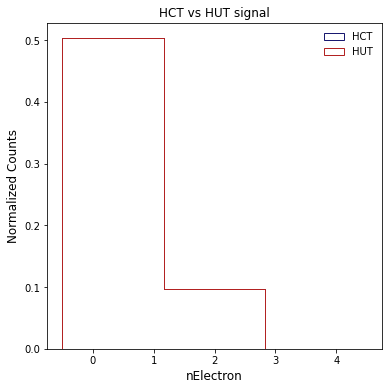

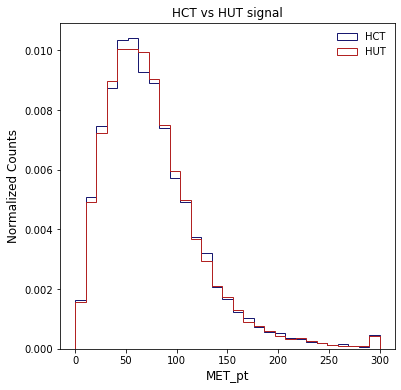

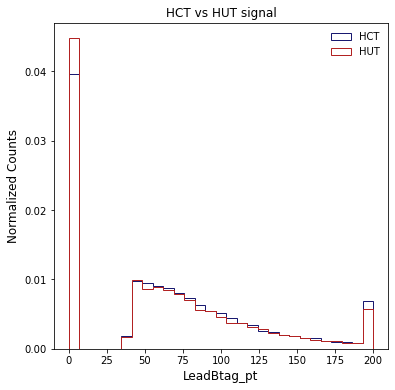

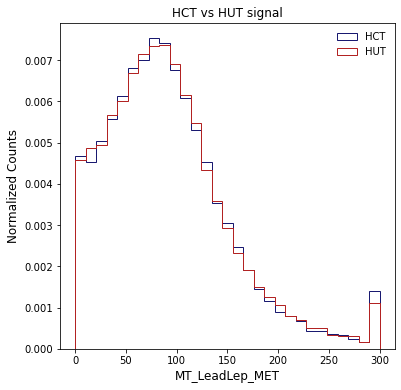

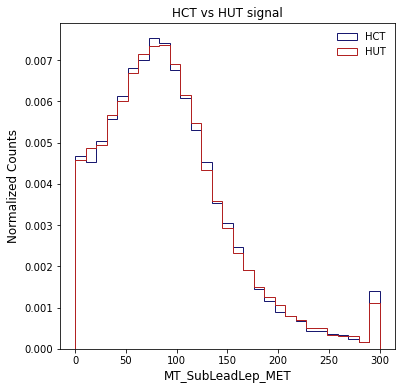

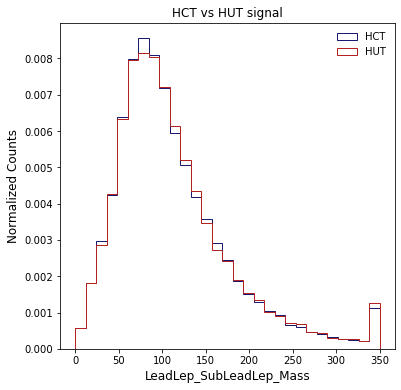

In [18]:
def gen_HCT_HUT_comparison(HCT_data, HUT_data, label, output_dir, region="signal", savefig=False):
    plt.figure(label, figsize=(6,6));
    bins = bins_dict[label]
    if region=="signal":
        HCT_values = HCT_data_train[label][HCT_data_train.Label == 's']
        HUT_values = HUT_data_train[label][HUT_data_train.Label == 's']
    elif region=="background":
        HCT_values = HCT_data_train[label][HCT_data_train.Label == 'b']
        HUT_values = HUT_data_train[label][HUT_data_train.Label == 'b']
#     values_signal = data_train[label][data_train.Label == 's']
#     values_background = data_train[label][data_train.Label == 'b']
    plt.hist(np.clip(HCT_values, bins[0], bins[-1]),bins=bins_dict[label],
             histtype='step',color='midnightblue',label='HCT', density=True);
    plt.hist(np.clip(HUT_values, bins[0], bins[-1]),bins=bins_dict[label],
             histtype='step',color='firebrick',label='HUT', density=True);

    log_params = ["SubLeadLep_dxy", "SubLeadLep_dz", "LeadLep_dxy", "LeadLep_dz"]
    if label in log_params:
        plt.yscale("log")
    plt.xlabel(label,fontsize=12);
    plt.ylabel('Normalized Counts',fontsize=12);
    plt.legend(frameon=False);
    plt.title("HCT vs HUT {}".format(region))
    if savefig:
        plt.savefig(output_dir + "histograms/{}.pdf".format(label))
    plt.draw()
    
for label in labels:
    gen_HCT_HUT_comparison(HCT_data_test, HUT_data_test, label, comparison_dir, "signal", savefig=True)

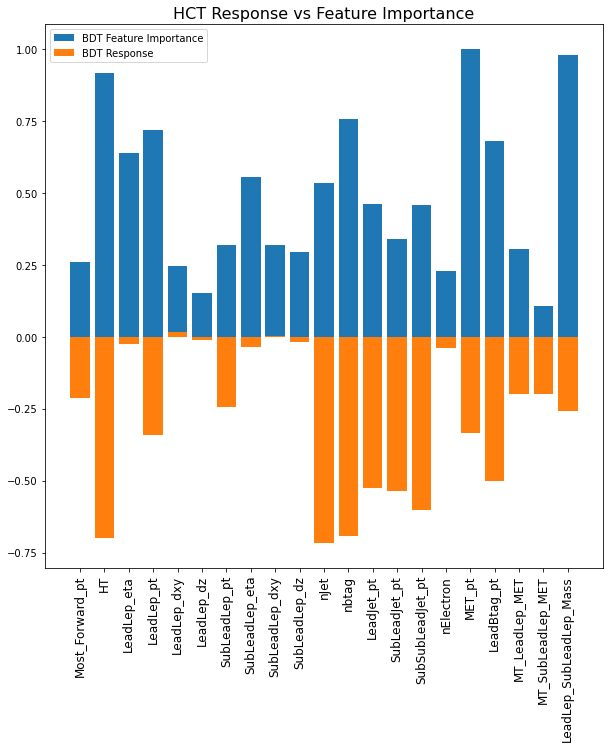

In [40]:
#plot the BDT response (correlation of BDT score with feature variables)
#also plot the feature importance for comparison
corr_df = data_test.copy()
corr_df["BDT_response"] = np.array(test_predictions)
fig, ax = plt.subplots(1,1,figsize=(10,10))
response = corr_df.corr().BDT_response
response_labels =  corr_df.select_dtypes(['number']).columns
bdt_fscore = np.array([booster.get_fscore()[l] for l in response_labels[1:-2]])
fscore_scale = np.max(bdt_fscore)
bdt_fscore = bdt_fscore / fscore_scale
bdt_fscore_plot = ax.bar(range(len(response[1:-2])), bdt_fscore, label = "BDT Feature Importance")
bdt_response_plot = ax.bar(range(len(response[1:-2])), response[1:-2], label = "BDT Response")

ax.set_xticks(range(len(response_labels)-3))
ax.set_xticklabels(response_labels[1:-2], rotation=90, fontdict={'fontsize':12})
ax.legend()
ax.set_title('{} Response vs Feature Importance'.format(signal_name), fontsize=16)
plt.draw()

Text(0.5, 1.0, 'Correlation Matrix')

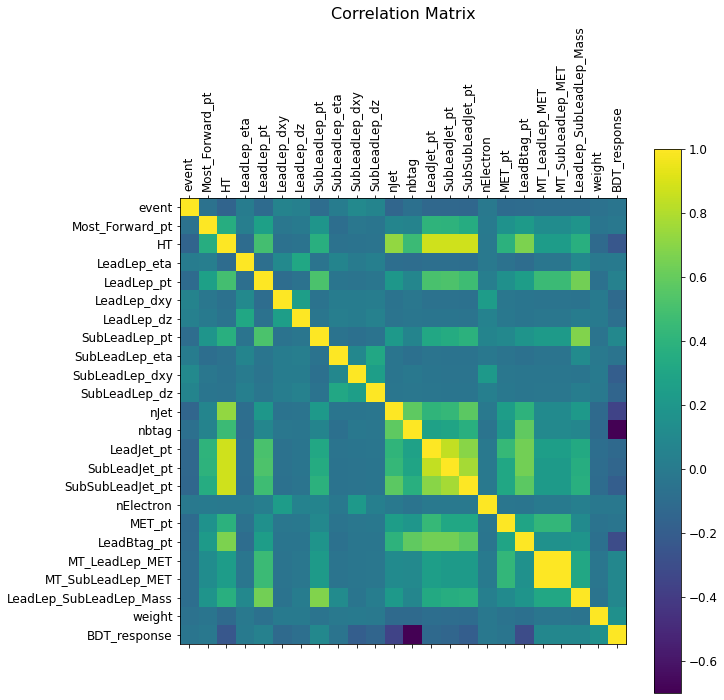

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

im = ax.matshow(corr_df.corr())
ax.set_xticks(range(corr_df.select_dtypes(['number']).shape[1]))
ax.set_xticklabels(corr_df.select_dtypes(['number']).columns, rotation=90, fontdict={'fontsize':12})
ax.set_yticks(range(corr_df.select_dtypes(['number']).shape[1]))
ax.set_yticklabels(corr_df.select_dtypes(['number']).columns, fontdict={'fontsize':12})
cbar = ax.figure.colorbar(im)
cbar.ax.tick_params(labelsize=12)

ax.set_title('Correlation Matrix', fontsize=16)

### Old Methods for BDT Parameter Optimization

In [221]:
#play around with lots of paramters
boosters = []
num_trees_list = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
lr_list = [n/0.017 for n in [1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3]]
depth_list = [2, 3, 4, 5, 6]
optimization_param = {}

# Booster parameters
param['eta']              = 3e-3 / 0.017 # learning rate
param['max_depth']        = 3  # maximum depth of a tree
param['subsample']        = 0.7 # fraction of events to train tree on
param['colsample_bytree'] = 0.7 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = num_trees_list[n] # number of trees to make


In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

class XGBoostRegressor():
    def __init__(self, num_boost_round=10, **params):
        self.clf = None
        self.num_boost_round = num_boost_round
        self.params = params
        self.params.update({'objective': 'reg:linear'})
 
    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = xgb.DMatrix(X, label=y)
        self.clf = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)
 
    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)
 
    def get_params(self, deep=True):
        return self.params
        
    def score(self, X, y):
        Y = self.predict(X)
        return np.sqrt(mean_squared_error(y, Y))
 
    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return self

#clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
clf_xgb = XGBoostRegressor(
    eval_metric = 'logloss',
    nthread = 4,
    eta = 0.1,
    num_boost_round = 80,
    max_depth = 5,
    subsample = 0.5,
    colsample_bytree = 1.0,
    silent = True,
    )
parameters = {
    'num_boost_round': [10, 25, 40, 50],
    'eta': [0.02, 0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'silent': [True]
}
y_train = data_train.Label.cat.codes
feature_names = data_train.columns[1:-2] 
x_train = data_train[feature_names]
cv = RandomizedSearchCV(clf_xgb, parameters, n_jobs=1, cv=2)


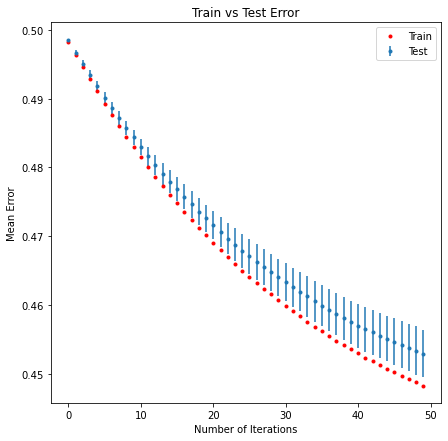

In [35]:
#print(cross_val)
plt.figure("cross_val", figsize = (7,7))
training_error = np.array(cross_val["train-rmse-mean"])
train_err_std = np.array(cross_val["train-rmse-std"])
booster_round = np.arange(0, (len(training_error)))
test_error = np.array(cross_val["test-rmse-mean"])
test_err_std = np.array(cross_val["test-rmse-std"])
plt.plot(booster_round, training_error, "r.", label="Train")
plt.errorbar(booster_round, test_error, yerr = test_err_std, fmt=".", label="Test")
plt.title("Train vs Test Error")
plt.xlabel("Number of Iterations")
plt.ylabel("Mean Error")
plt.legend()
#plt.yscale("log")
plt.draw()
#print(cross_val)

In [29]:
cv.fit(x_train, y_train)
cv.best_params_

[08:09:24] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:24] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:32] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:32] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:39] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:s

RandomizedSearchCV(cv=2,
                   estimator=<__main__.XGBoostRegressor object at 0x7f9cc8a5c790>,
                   n_jobs=1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'eta': [0.02, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 4, 5],
                                        'num_boost_round': [10, 25, 40, 50],
                                        'silent': [True],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]})

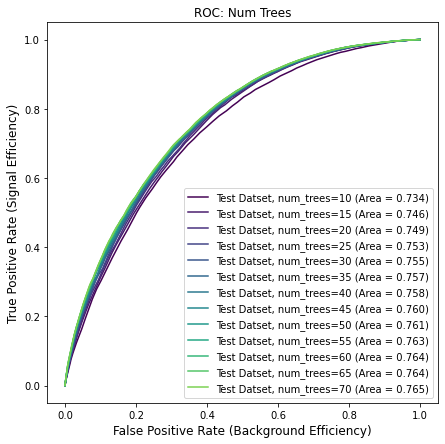

In [223]:
def gen_TPR_FPR(booster, color1, color2, label, ax, plot_train=True, plot_test=True):
    test_predictions = booster.predict(test)
    train_predictions = booster.predict(train)
    cuts = np.linspace(0,1,200);
    # TPR = TP / (TP + FN)
    # FPR = FP / (FP + TN)
    train_TP = np.zeros(len(cuts))
    train_FP = np.zeros(len(cuts))
    train_TN = np.zeros(len(cuts))
    train_FN = np.zeros(len(cuts))
    test_TP = np.zeros(len(cuts))
    test_FP = np.zeros(len(cuts))
    test_TN = np.zeros(len(cuts))
    test_FN = np.zeros(len(cuts))

    for i,cut in enumerate(cuts):
        train_pos = (train_predictions >  cut)
        train_neg = (train_predictions <= cut)
        train_TP[i] = np.sum(train.get_weight()[(data_train.Label=='s') & train_pos])
        train_FP[i] = np.sum(train.get_weight()[(data_train.Label=='b') & train_pos])
        train_TN[i] = np.sum(train.get_weight()[(data_train.Label=='b') & train_neg])
        train_FN[i] = np.sum(train.get_weight()[(data_train.Label=='s') & train_neg])

        test_pos = (test_predictions >  cut)
        test_neg = (test_predictions <= cut)
        test_TP[i] = np.sum(test.get_weight()[(data_test.Label=='s') & test_pos])
        test_FP[i] = np.sum(test.get_weight()[(data_test.Label=='b') & test_pos])
        test_TN[i] = np.sum(test.get_weight()[(data_test.Label=='b') & test_neg])
        test_FN[i] = np.sum(test.get_weight()[(data_test.Label=='s') & test_neg])
    

    # plot efficiency vs. purity (ROC curve)
    train_TPR = train_TP / (train_TP + train_FN)
    train_FPR = train_FP / (train_FP + train_TN)
    train_AUC = auc(train_FPR, train_TPR)
    
    test_TPR = test_TP / (test_TP + test_FN)
    test_FPR = test_FP / (test_FP + test_TN)
    test_AUC = auc(test_FPR, test_TPR)
    AUC_difference = np.abs(train_AUC - test_AUC)
    if AUC_difference < 0.02:
        ax.plot(test_FPR, test_TPR, '-', color=color1, label="Test Datset, {0}(Area = {1:.3f})".format(label, test_AUC))
        #ax.plot(train_FPR, train_TPR, '--', color=color2, label="Train Datset, {0}(Area = {1:.3f})".format(label, train_AUC))
    
plt.figure(figsize=(7,7));
num_param = len(num_trees_list)
for i in range(0, num_param-2):
    label = "num_trees={0} ".format(num_trees_list[i])
    gen_TPR_FPR(booster=boosters[i], color1=cm.viridis(i * 256//15), color2="red", label=label, ax=plt.gca())
    plt.xlabel('False Positive Rate (Background Efficiency)',fontsize=12);
    plt.ylabel('True Positive Rate (Signal Efficiency)',fontsize=12);

plt.legend()
plt.title("ROC: Num Trees")
plt.draw()

There is not a lot of discriminating power in that variable. For fun, we can plot it with the next most important feature:

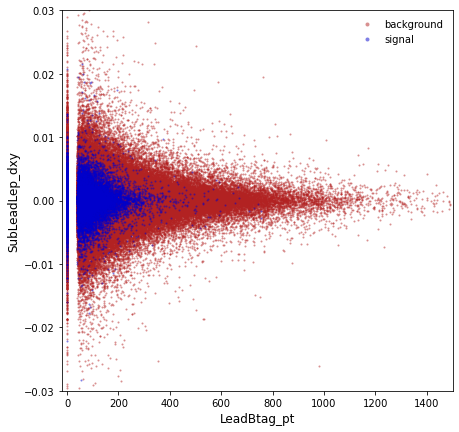

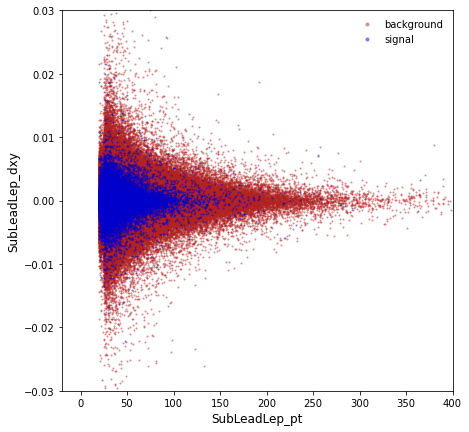

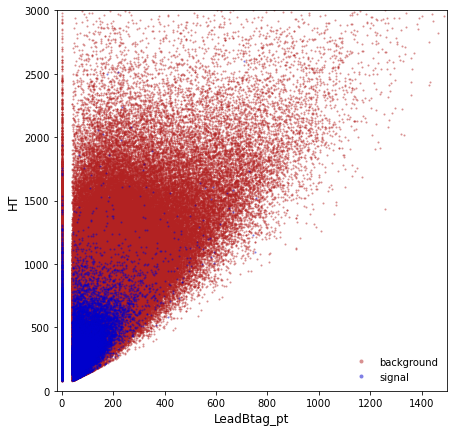

In [70]:
plt.figure("leadbtag_dxy", figsize=(7,7));
plt.plot(data_train.LeadBtag_pt[data_train.Label == 'b'],data_train.SubLeadLep_dxy[data_train.Label == 'b'],
         'o',markersize=2,color='firebrick',markeredgewidth=0,alpha=0.5,label='background');
plt.plot(data_train.LeadBtag_pt[data_train.Label == 's'],data_train.SubLeadLep_dxy[data_train.Label == 's'],
         'o',markersize=2,color='mediumblue',markeredgewidth=0,alpha=0.5,label='signal');
plt.xlabel('LeadBtag_pt',fontsize=12);
plt.ylabel('SubLeadLep_dxy',fontsize=12);
plt.xlim([-20, 1500])
plt.ylim([-0.03, 0.03])
plt.legend(frameon=False,numpoints=1,markerscale=2);

plt.figure("dxy_pt", figsize=(7,7));
plt.plot(data_train.SubLeadLep_pt[data_train.Label == 'b'],data_train.SubLeadLep_dxy[data_train.Label == 'b'],
         'o',markersize=2,color='firebrick',markeredgewidth=0,alpha=0.5,label='background');
plt.plot(data_train.SubLeadLep_pt[data_train.Label == 's'],data_train.SubLeadLep_dxy[data_train.Label == 's'],
         'o',markersize=2,color='mediumblue',markeredgewidth=0,alpha=0.5,label='signal');
plt.xlabel('SubLeadLep_pt',fontsize=12);
plt.ylabel('SubLeadLep_dxy',fontsize=12);
plt.xlim([-20, 400])
plt.ylim([-0.03, 0.03])
plt.legend(frameon=False,numpoints=1,markerscale=2);

plt.figure("leadbtag_ht", figsize=(7,7));
plt.plot(data_train.LeadBtag_pt[data_train.Label == 'b'],data_train.HT[data_train.Label == 'b'],
         'o',markersize=2,color='firebrick',markeredgewidth=0,alpha=0.5,label='background');
plt.plot(data_train.LeadBtag_pt[data_train.Label == 's'],data_train.HT[data_train.Label == 's'],
         'o',markersize=2,color='mediumblue',markeredgewidth=0,alpha=0.5,label='signal');
plt.xlabel('LeadBtag_pt',fontsize=12);
plt.ylabel('HT',fontsize=12);
plt.xlim([-20, 1500])
plt.ylim([0, 3000])
plt.legend(frameon=False,numpoints=1,markerscale=2);

### Old way of getting BDT parameters